# Preparing and modelling our dataset

In [732]:
# Standard Data Analysis Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Tensorflow libraries
import tensorflow as tf
import keras

## Creating the Dataset

Firstly let us create a Tensorflow dataset of our images. We then split this dataset into a: 
- Train Dataset
- Validation Dataset and
- Test Dataset

In [733]:
from keras.utils import image_dataset_from_directory
from math import ceil

In [734]:
img_width = 64
img_height = 64

data_directory = r"C:\Users\Gordon Li\Desktop\computer_vision\images"
dataset = image_dataset_from_directory(
    data_directory, validation_split=0, batch_size=None, image_size=(img_width, img_height)
)

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = ceil(0.8 * dataset_size)

train_ds = dataset.take(train_size)
temp_ds = dataset.skip(train_size)
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
assert(train_size == train_ds_size) 
print("The training set size is", train_ds_size)

temp_ds_size = tf.data.experimental.cardinality(temp_ds).numpy()
assert(temp_ds_size == (dataset_size - train_size))

val_size = ceil(0.5 * temp_ds_size)
val_ds = temp_ds.take(val_size)
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
assert(val_size == val_ds_size)
print("The validation set size is", val_ds_size)

test_ds = temp_ds.skip(val_size)
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy() 
assert(test_ds_size == (temp_ds_size - val_size))
print("The test set size is", test_ds_size)

temp_ds = dataset.take(train_size)

Found 5630 files belonging to 10 classes.
The training set size is 4504
The validation set size is 563
The test set size is 563


In [735]:
# Denoting each image label digit (0-9) 
from get_images import landmark_shorthand
import os
from location_landmark_dict import location_landmark, alt_names

landmark_list = list(location_landmark.keys())
shorthand_to_landmark = {}
for landmark in landmark_list: 
    shorthand = landmark_shorthand(alt_names, landmark)
    shorthand_to_landmark[shorthand] = landmark

image_directories_list = os.listdir(data_directory)
label_to_landmark_dict = {}
for i, shorthand in enumerate(image_directories_list):
    label_to_landmark_dict[i] = shorthand_to_landmark[shorthand]
print(label_to_landmark_dict)

{0: 'Arc de Triomphe', 1: 'Big Ben', 2: 'Brooklyn Bridge', 3: 'The Colosseum', 4: 'Eiffel Tower', 5: 'Great Wall of China', 6: 'Sensoji Temple', 7: 'Sydney Opera House', 8: 'Times Square', 9: 'Trevi Fountain'}


## Image Augmentation

In [736]:
from keras import Sequential
from keras.layers import RandomBrightness, RandomContrast, RandomFlip, RandomRotation
from keras.layers import Rescaling

InitialAugmentation = tf.keras.Sequential([
    RandomContrast(0.1),
    RandomBrightness(0.1),
    RandomRotation(factor=(-0.1, 0.1)),
])

RescaledLayer = tf.keras.Sequential([
    Rescaling(1.0/255)
])

In [737]:
import matplotlib.pyplot as plt
from keras.layers import Resizing

In [738]:
def dataset_preparation(dataset, augment, pixel_size=64, shown=False): 
    def image_show(dataset):
        fig, axs = plt.subplots(5, 3, figsize=(12, 20))
        fig.suptitle("A brief look of Randomly augmented images")
        axs = axs.ravel()
        i = 0 
        for images, label in dataset.take(15): 
            axs[i].imshow(images.numpy().astype("uint8"))
            axs[i].set_title(f"Image {i+1}")
            axs[i].axis("off")
            i += 1
        plt.show()
    
    if (augment == True): 
        dataset = dataset.map(
            lambda x, y: (InitialAugmentation(x), y)
        )
        if (shown == True):
            image_show(dataset)
        
    dataset = dataset.shuffle(1024)
    
    dataset = dataset.map(
        lambda x, y: (RescaledLayer(x), y)
    )
    
    if pixel_size != 64: 
        ReSizedLayer = tf.keras.Sequential([
            Resizing(pixel_size, pixel_size)
        ])
        dataset = dataset.map(
            lambda x, y: (ReSizedLayer(x), y)
        )
    
    return dataset.prefetch(tf.data.AUTOTUNE).cache()

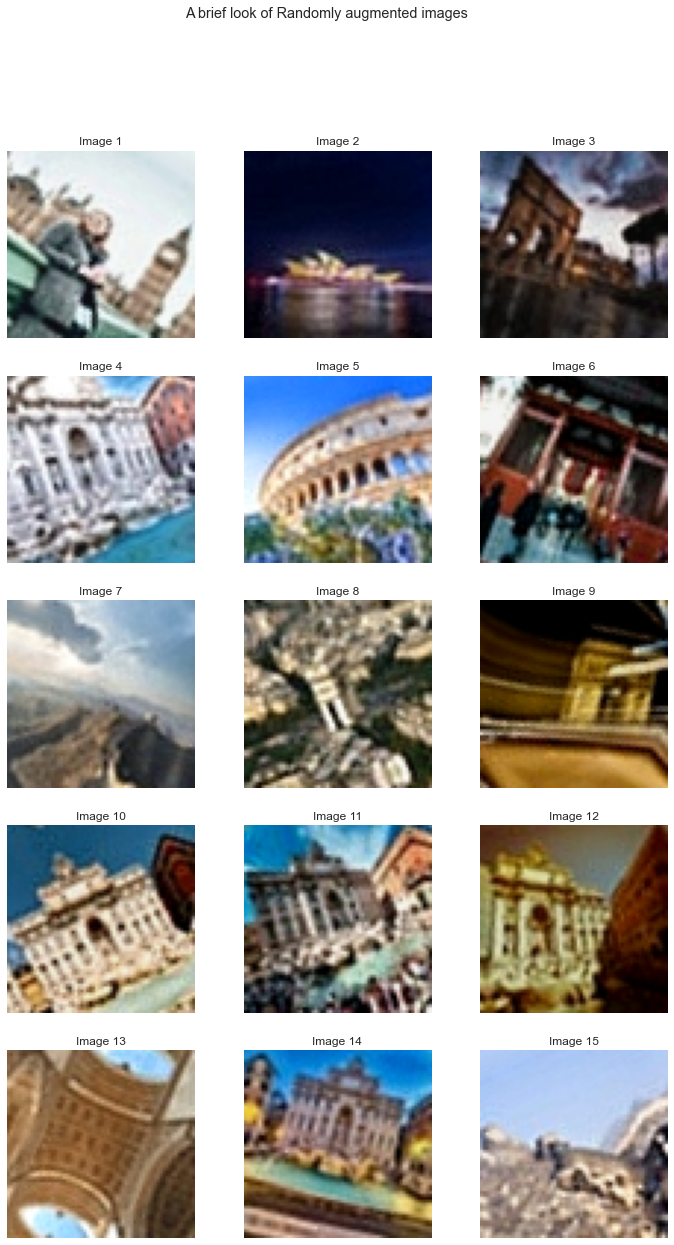

In [739]:
train_lc = dataset_preparation(train_ds, augment=True)
train_nn = dataset_preparation(train_ds, augment=True, shown=True)
train_alexnet = dataset_preparation(train_ds, augment=True, pixel_size=227)
val_lc = dataset_preparation(val_ds, augment=False)
val_nn = dataset_preparation(val_ds, augment=False)
val_alexnet = dataset_preparation(val_ds, augment=False, pixel_size=227)
test_lc = dataset_preparation(test_ds, augment=False)
test_nn = dataset_preparation(test_ds, augment=False)
test_alexnet = dataset_preparation(test_ds, augment=False, pixel_size=227)

## Our models

### Our Utility Functions

In [740]:
def normalise_flatten_data(train, val, test, flatten): 
    """
    - Normalises our image data by the subtracting the mean from it. 
    - Can also flatten image data for the SGDClassifier
    """
    X_train = tf.convert_to_tensor(list(train.map(lambda x, y: x)))
    y_train = tf.convert_to_tensor(list(train.map(lambda x, y: y)))
    X_val = tf.convert_to_tensor(list(val.map(lambda x, y: x)))
    y_val = tf.convert_to_tensor(list(val.map(lambda x, y: y)))
    X_test = tf.convert_to_tensor(list(test.map(lambda x, y: x)))
    y_test = tf.convert_to_tensor(list(test.map(lambda x, y: y)))
    
    mean_one = tf.math.reduce_mean(X_train, 0, keepdims=True)
    mean_two = tf.math.reduce_mean(mean_one, 1, keepdims=True)
    mean = tf.math.reduce_mean(mean_two, 2, keepdims=True)
    
    X_train = X_train - mean
    X_val = X_val - mean
    X_test_og = 255 * X_test
    X_test = X_test - mean
    
    assert(X_train.shape[0] == len(y_train))
    assert(X_val.shape[0] == len(y_val))
    assert(X_test.shape[0] == len(y_val))

    if (flatten == True):
        X_train = tf.reshape(X_train, [X_train.shape[0], -1])
        X_val = tf.reshape(X_val, [X_val.shape[0], -1])
        X_test = tf.reshape(X_test, [X_test.shape[0], -1])
    
    return X_train, y_train, X_val, y_val, X_test, X_test_og, y_test

In [741]:
from sklearn.metrics import accuracy_score

class AccuracyPrediction(): 
    """
    A class 
    - that predicts the probability or prediction classifcation via the ML model
    using the predict function
    - that gets the accuracy and loss when a image dataset is loaded into the model
    """
    def __init__(self, data, model_type):
        self.data = data
        self.type = model_type
        self.features = [x[0] for x in data]
        self.target_pred_dict = None
        self.target_probs_dict = None
        
    def predict(self, model): 
        target_probs_dict, target_pred_dict = {}, {}
        for i, (feature, _) in enumerate(self.data): 
            if (self.type == "neural network"):
                target_probs_dict[i] = model.predict(feature, verbose=0)
                target_pred_dict[i] = np.argmax(target_probs_dict[i], 1)
            else:
                target_probs_dict[i] = model.predict_proba(feature)
                target_pred_dict[i] = model.predict(feature)
        self.target_probs_dict = target_probs_dict
        self.target_pred_dict = target_pred_dict
        return target_probs_dict, target_pred_dict
    
    def get_acc_loss(self, model): 
        data_dictionary = {0: "training data", 1: "validation data", 2: "testing data"}
        for i, (feature, target) in enumerate(self.data): 
            if (self.type == "neural network"):
                loss, accuracy = model.evaluate(feature, target, verbose=0)
                print(f"The loss of our {data_dictionary[i]} is {round(loss, 2)}.")
            else: 
                y_pred = self.target_pred_dict[i]
                accuracy = accuracy_score(target, y_pred)
            print(f"The accuracy of our {data_dictionary[i]} is {round(accuracy, 2)}.")

In [742]:
def assert_correct_shape(dictionary, data, param_type):
    """
    Checks the correct shape of prediction and probability dictionaries
    """ 
    for i in range(len(dictionary)): 
        if (param_type == "prediction"):
            assert(len(dictionary[i]) == len(data[i][1]))
        else: 
            assert(dictionary[i].shape[0] == data[i][0].shape[0]) 
            assert(dictionary[i].shape[1] == 10)

In [743]:
from numpy.random import choice, seed
seed(20)

def show_correct_images(data, pred_dictionary, param_type):     
    """
    Plots images that is classified correctly and incorrectly (adjusted through
    parameter type)
    """
    y_test_pred = pred_dictionary[2]
    if (param_type == "correct"):
        title = "Images of correct classification"
        locations = np.where(np.equal(y_test_pred, data[2][1]))[0]
    else: 
        title = "Images of Incorrect classification (Error Analysis)"
        locations = np.where(np.not_equal(y_test_pred, data[2][1]))[0]
    selected_images_indices = choice(locations, size=9, replace=False)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    fig.suptitle(title)
    axs = axs.ravel()
    for i, index in enumerate(selected_images_indices): 
        image = X_test_og[index].numpy()
        axs[i].imshow(image.astype('uint8'))
        if (param_type == "correct"):
            axs[i].set_title(f"Image {i+1}: {label_to_landmark_dict[y_test_pred[index]]}")
        else: 
            axs[i].set_title(
                f"Image {i+1}: Correct - {label_to_landmark_dict[y_test[index].numpy()]}"
            )
            axs[i].set_xlabel(
                f"Predicted - {label_to_landmark_dict[y_test_pred[index]]}"
            )
        axs[i].grid(False)
    plt.tight_layout()
    plt.show()

In [744]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve, roc_auc_score
lb = LabelBinarizer() 

In [745]:
def plot_all_curves(model, model_type, data):
    """
    Plots the ROC curve of each of our landmark given the deep learning model
    """
    NUM_CLASSES = 10 
    color_palette = [
        "#FF6E7F", "#06D6A0", "#DAA520", "#A04000", "#F5A623", 
        "#98C6D3", "#BF6F7A", "#E5C2C0", "#383E56", "#F7CED7"
    ]
    plot_position = {0: "Training Data", 1: "Validation Data", 2: "Testing Data"}
    def plot_roc_curve(model, features, target, color_palette, ax, pos): 
        if (model_type == "neural_network"):
            y_probs = model.predict(features, verbose=0)
        else: 
            y_probs = model.predict_proba(features)
        transformed = lb.transform(target)
        for i, color in zip(range(NUM_CLASSES), color_palette): 
            fpr, tpr, _ = roc_curve(transformed[:, i], y_probs[:, i])
            auc_score = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=color, label=f"{label_to_landmark_dict[i]} (area = {auc_score})")
            ax.set_xlabel("False Positive Rate")
            ax.legend(loc="lower right")
        ax.set_title(plot_position[pos])
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("ROC Curve of our training, validation and testing data")
    fig.supylabel("True Positive Rate")
    for i, (features, target) in enumerate(data):
        plot_roc_curve(model, features, target, color_palette, axs[i], i)
    plt.show()

In [746]:
from sklearn.preprocessing import OneHotEncoder

class RocAucScore(): 
    
    def __init__(self, data, probs_dict, y_train): 
        enc = OneHotEncoder()
        enc.fit(y_train.numpy().reshape(-1, 1))
        
        encoded_list = []
        for i in range(len(data)):
            y_value = data[i][1].numpy().reshape(-1, 1)
            y_encoded = enc.transform(y_value).toarray()
            encoded_list.append(y_encoded)
        self.encoded = encoded_list
        
        probs_list = []
        for value in probs_dict.values(): 
            probs_list.append(value)
        self.probs = probs_list
        
    def compute(self, start=0): 
        data_dict = {0: "training set", 1: "validation set", 2: "testing set"}
        i = 0
        roc_auc = None
        for y_encoded, y_probs in zip(self.encoded[start:], self.probs[start:]): 
            roc_auc = roc_auc_score(y_encoded, y_probs, multi_class="ovo")
            print(f"The ROC-AUC score for our {data_dict[i]} is {round(roc_auc,3)}")
            i += 1

In [747]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model_type, y_test, dict_preds):
    """
    Plots confusion matrix of our model
    """
    plt.figure(figsize=(10, 10))
    cm = confusion_matrix(y_test, dict_preds[2])
    xticklabels = list(label_to_landmark_dict.values())
    yticklabels = list(label_to_landmark_dict.values()) 
    sns.heatmap(cm, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)
    plt.title(f"Confusion matrix for our {model_type} model")
    plt.xlabel("Prediction Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [748]:
from sklearn.metrics import classification_report
def print_classification_report(y_true, y_pred):
    """
    Prints classification report of our model
    """
    target_names = list(label_to_landmark_dict.values())
    print(classification_report(y_true, y_pred, target_names=target_names))

### Benchmark Model: Linear Classifier

#### Obtaining and Normalising our image data

In [749]:
X_train, y_train, X_val, y_val, X_test, X_test_og, y_test = normalise_flatten_data(
    train_lc, val_lc, test_lc, flatten=True
)

#### Our Baseline Model

In [750]:
# IGNORE CONVERGENCE WARNING
from sklearn.linear_model import SGDClassifier
initial_sgd_model = SGDClassifier(loss="log_loss", n_jobs=-1, random_state=12)
initial_sgd_model.fit(X_train, y_train)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=12)

In [751]:
y_pred = initial_sgd_model.predict(X_test)
print(f"The accuracy score of our inital SGDClassifier model for the testing data is {round(accuracy_score(y_test, y_pred), 2)}.")

The accuracy score of our inital SGDClassifier model for the testing data is 0.32.


#### Hyperparameter tuning

In [752]:
"""
Hyperparameter tuning our regularisation parameter
"""
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
validation_accuracy_list = []
for reg in alphas: 
    clf = SGDClassifier(loss="log_loss", n_jobs=-1, alpha=reg, random_state=12)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    validation_accuracy_list.append(accuracy)

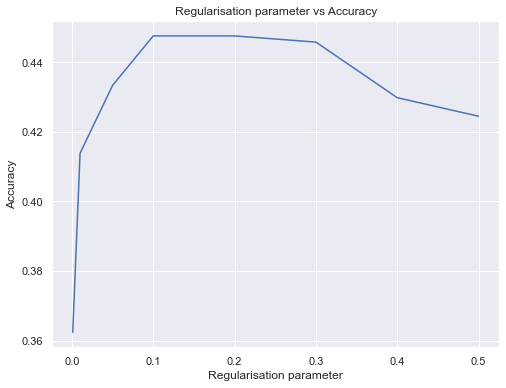

In [753]:
sns.set()
plt.figure(figsize=(8, 6))
plt.title("Regularisation parameter vs Accuracy")
plt.xlabel("Regularisation parameter")
plt.ylabel("Accuracy")
plt.plot(alphas, validation_accuracy_list)
plt.show()

In [754]:
index = np.argmax(validation_accuracy_list)
best_accuracy = validation_accuracy_list[index]
best_alpha = alphas[index]
print(f"Our best model achieved a validation accuracy score of {round(best_accuracy, 2)}\
 with a regularisation parameter alpha of value {best_alpha}.")

Our best model achieved a validation accuracy score of 0.45 with a regularisation parameter alpha of value 0.1.


#### Our Best Model

##### Training the Model

In [755]:
from sklearn.linear_model import SGDClassifier
best_sgd_model = SGDClassifier(loss="log_loss",  n_jobs=-1, alpha=best_alpha, random_state=12)
best_sgd_model.fit(X_train, y_train)

SGDClassifier(alpha=0.1, loss='log_loss', n_jobs=-1, random_state=12)

##### Model Evaluation Metrics

**Prediction Evaluation**

In [756]:
data = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

sgd_acc_pred = AccuracyPrediction(data, "sgd")
sgd_target_probs, sgd_target_preds = sgd_acc_pred.predict(best_sgd_model)

In [757]:
assert_correct_shape(sgd_target_probs, data, "probs")
assert_correct_shape(sgd_target_preds, data, "prediction")

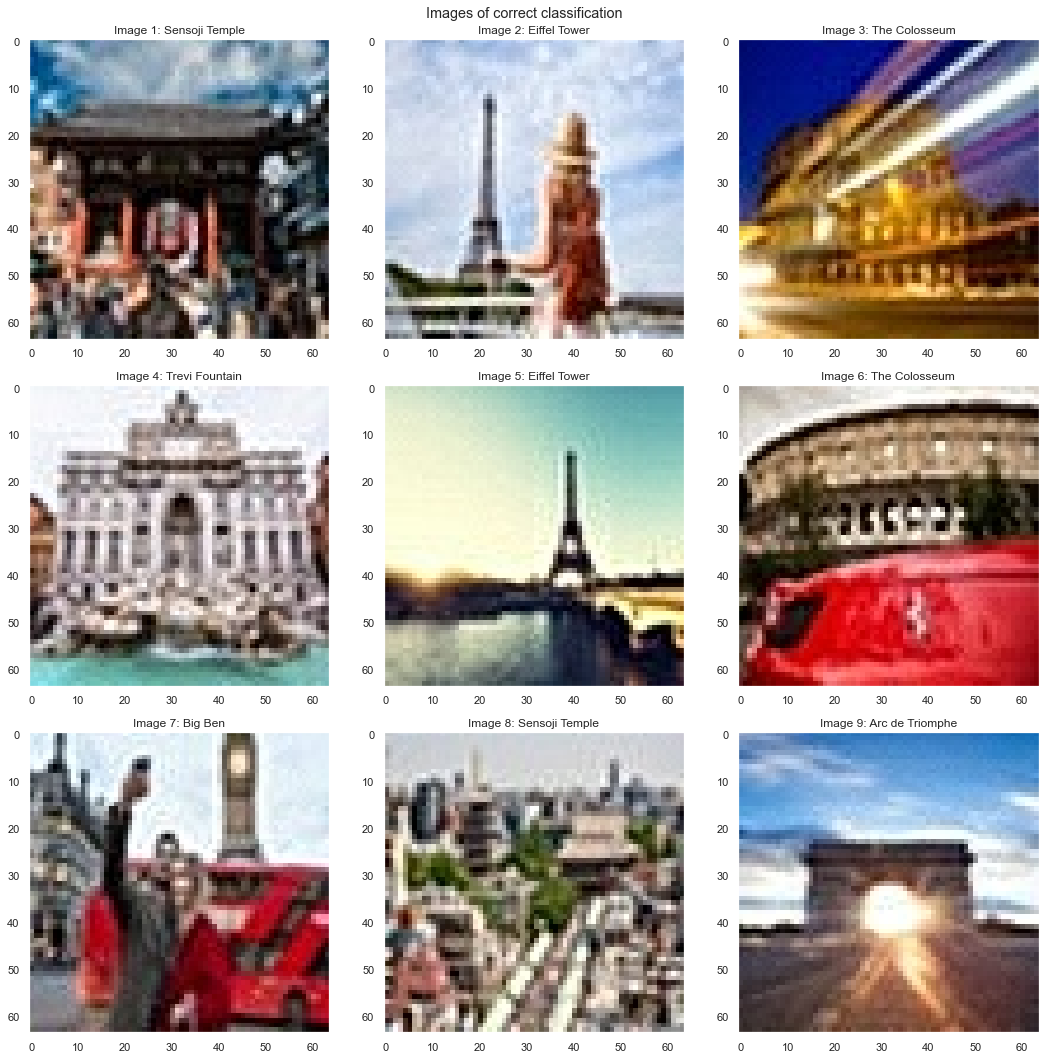

In [758]:
show_correct_images(data, sgd_target_preds, "correct")

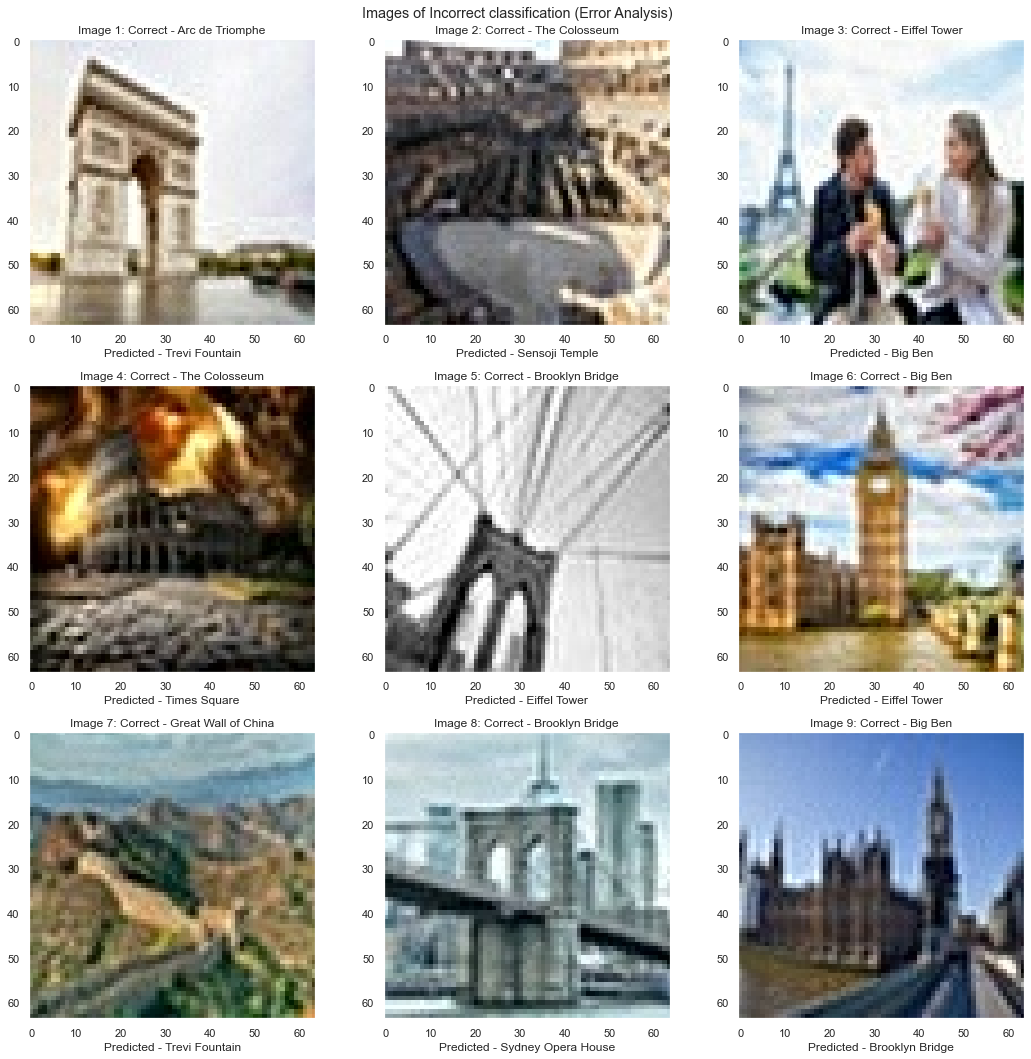

In [759]:
show_correct_images(data, sgd_target_preds, "incorrect")

**Accuracy Evaluation**

In [760]:
sgd_acc_pred.get_acc_loss(best_sgd_model)

The accuracy of our training data is 0.48.
The accuracy of our validation data is 0.45.
The accuracy of our testing data is 0.41.


**ROC-AUC Scores**

In [761]:
lb.fit(y_train)

LabelBinarizer()

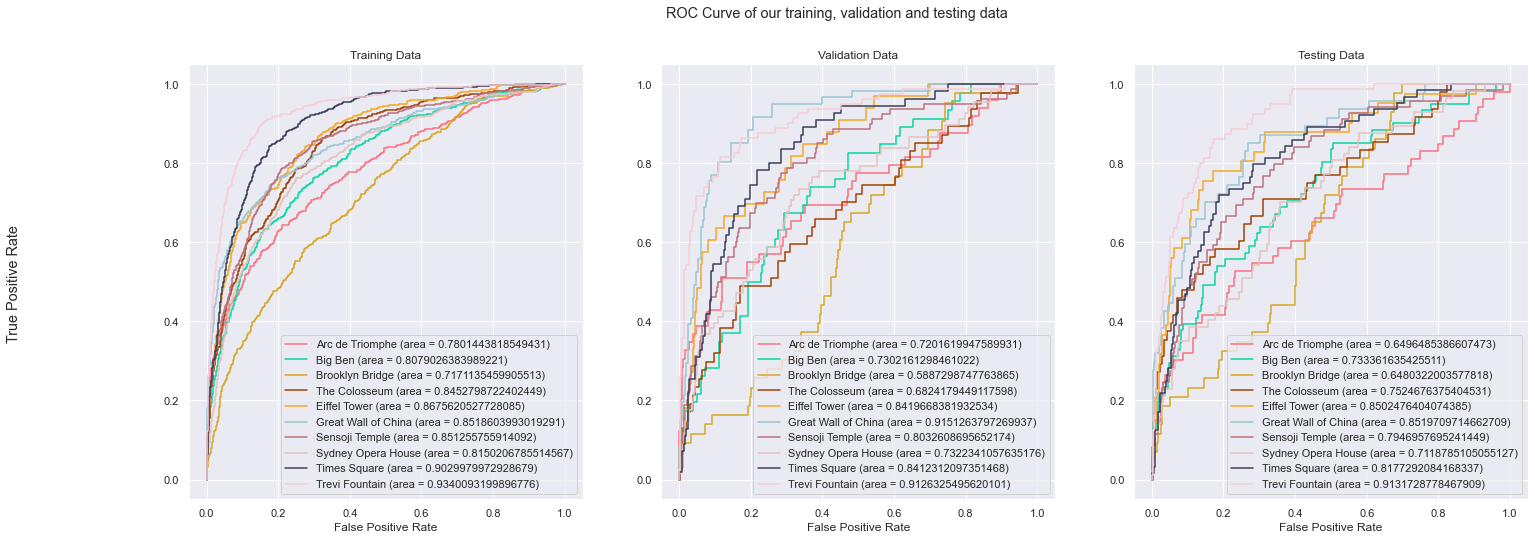

In [762]:
plot_all_curves(best_sgd_model, "sgd", data)

In [763]:
roc_auc_sgd = RocAucScore(data, sgd_target_probs, y_train)
roc_auc_sgd.compute()

The ROC-AUC score for our training set is 0.837
The ROC-AUC score for our validation set is 0.777
The ROC-AUC score for our testing set is 0.772


**Classification Report**

In [764]:
print_classification_report(y_test, sgd_target_preds[2])

                     precision    recall  f1-score   support

    Arc de Triomphe       0.48      0.19      0.27        53
            Big Ben       0.46      0.26      0.33        61
    Brooklyn Bridge       0.20      0.07      0.10        43
      The Colosseum       0.53      0.21      0.30        48
       Eiffel Tower       0.47      0.46      0.47        41
Great Wall of China       0.40      0.51      0.45        47
     Sensoji Temple       0.34      0.57      0.42        69
 Sydney Opera House       0.28      0.35      0.31        57
       Times Square       0.49      0.36      0.41        64
     Trevi Fountain       0.50      0.86      0.63        80

           accuracy                           0.41       563
          macro avg       0.41      0.38      0.37       563
       weighted avg       0.42      0.41      0.39       563



### Deep Learning: Neural Networks

Before we begin to explore these two neural network architectures, it is necessary to: 
- Import the Necessary Libraries to carry out our exploration and, 
- Produce various classes and functions that will help us analyse our neural network architectures better

In [765]:
from keras import Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import load_model
from keras.utils import plot_model

import keras_tuner as kt

In [766]:
class ModelFitter(): 
    """
    Fits a particular model using the functional api
    """
    def __init__(self, dropout_rate, learning_rate): 
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        
    def functional_model(self, method_type, size): 
        model_subclassed = None
        model_subclassed = method_type(dropout_rate=self.dropout_rate)
        inputs = Input(shape=(size, size, 3), name="inputs")
        model = Model(inputs, model_subclassed.call(inputs))
        return model
    
    def compile(self, model): 
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate), 
            loss=SparseCategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        return model
    
    def fit(self, model, X_train, y_train, X_val, y_val, epochs, callbacks, verbose): 
        model_history = model.fit(
            X_train, y_train, batch_size=32, callbacks=callbacks,
            validation_data=(X_val, y_val), verbose=verbose, epochs=epochs
        )
        return model_history

In [767]:
def plot_history(history):
    """
    Plots loss and accuracy train and validation history of our model
    """
    no_epochs = len(history.history["loss"])
    epochs = [i for i in range(1, no_epochs + 1)]
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("A plot of the number of epochs against the loss and accuracies")
    axs = axs.ravel()
    axs[0].plot(epochs, train_loss, color="blue", label="Training")
    axs[0].plot(epochs, val_loss, color="orange", linestyle="dashed", label="Validation")
    axs[0].set_title("Epoch vs Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc="upper right")
    
    axs[1].plot(epochs, train_accuracy, color="blue", label="Training")
    axs[1].plot(epochs, val_accuracy, color="orange", linestyle="dashed", label="Validation")
    axs[1].set_title("Epoch vs Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc="lower right")
    plt.show()

In [768]:
def get_epoch(model_history):
    epoch_lowest = np.argmin(model_history.history["val_loss"])
    loss_lowest = model_history.history["val_loss"][epoch_lowest]
    accuracy = model_history.history["val_accuracy"][epoch_lowest]
    print(f"The epoch with the lowest validation score is {epoch_lowest + 1}.")
    print(f"The validation loss for this epoch is {round(loss_lowest, 2)}.")
    print(f"The validation accuracy score for this epoch is {round(accuracy, 2)}")

#### Artificial Neural Network

##### Obtaining and normalising our image data

In [769]:
X_train, y_train, X_val, y_val, X_test, X_test_og, y_test = normalise_flatten_data(
    train_nn, val_nn, test_nn, flatten=False
)

##### Our Baseline Model

Our baseline model consists of: 
- A Flattened layer which flattens input images from $(64, 64, 3)$ to $(12288, )$.
- A first hidden layer with 3200 neurons and an activation of relu,
- A dropout layer with a dropout rate of 0.1,
- A first hidden layer with 500 neurons and an activation of relu,
- A third hidden layer with 128 neurons and an activation of relu and
- An output layer with 10 neurons (representing the number of classes) and activation of softmax

**Training the model**

In [770]:
class ArtificialNeuralNetwork(tf.keras.Model): 
    def __init__(self, dropout_rate): 
        super(ArtificialNeuralNetwork, self).__init__()
        self.flatten = Flatten(input_shape=(64, 64, 3), name="flatten")
        self.hidden1 = Dense(3200, activation="relu", name="hidden_1")
        self.dropout1 = Dropout(dropout_rate, name="dropout_1")
        self.hidden2 = Dense(500, activation="relu", name="hidden_2")
        self.hidden3 = Dense(128, activation="relu", name="hidden_3")
        self.main_output = Dense(10, activation="softmax", name="output")
    
    def call(self, input): 
        x = self.flatten(input)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        return self.main_output(x)

In [771]:
model_fitter_ann = ModelFitter(0.1, 0.001)
initial_functional_ann_model = model_fitter_ann.functional_model(ArtificialNeuralNetwork, size=64)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/ann/initial_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]
initial_ann_model = model_fitter_ann.compile(initial_functional_ann_model)
ann_model_history = model_fitter_ann.fit(
    initial_ann_model, X_train, y_train, X_val, y_val, epochs=20, callbacks=callbacks, verbose=1
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 2.4256 - accuracy: 0.2436
Epoch 1: val_loss improved from inf to 1.96822, saving model to checkpoints/ann\initial_model.hdf5
141/141 [==============================] - 19s 134ms/step - loss: 2.4256 - accuracy: 0.2436 - val_loss: 1.9682 - val_accuracy: 0.3375
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 1.8439 - accuracy: 0.3612
Epoch 2: val_loss improved from 1.96822 to 1.75967, saving model to checkpoints/ann\initial_model.hdf5
141/141 [==============================] - 20s 141ms/step - loss: 1.8439 - accuracy: 0.3612 - val_loss: 1.7597 - val_accuracy: 0.4032
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 1.6684 - accuracy: 0.4307
Epoch 3: val_loss improved from 1.75967 to 1.70821, saving model to checkpoints/ann\initial_model.hdf5
141/141 [==============================] - 19s 135ms/step - loss: 1.6684 - accuracy: 0.4307 - val_loss: 1.7082 - val_accuracy: 0.4174
Epoch

**A plot of our model**

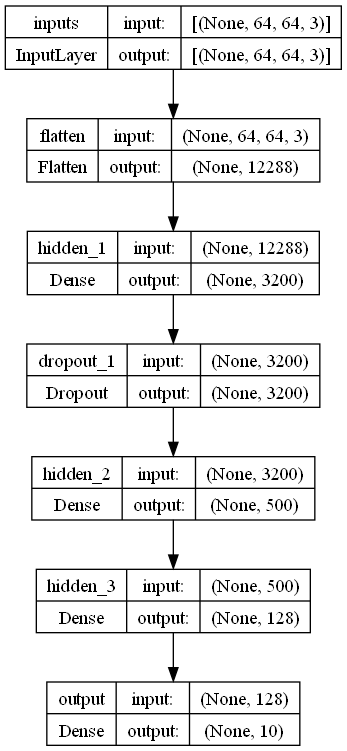

In [772]:
plot_model(initial_ann_model, show_shapes=True, show_layer_names=True)

**Loading the best model**

In [773]:
initial_ann_model = load_model("checkpoints/ann/initial_model.hdf5")

**Evaluation Metrics**

In [774]:
initial_ann_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 hidden_1 (Dense)            (None, 3200)              39324800  
                                                                 
 dropout_1 (Dropout)         (None, 3200)              0         
                                                                 
 hidden_2 (Dense)            (None, 500)               1600500   
                                                                 
 hidden_3 (Dense)            (None, 128)               64128     
                                                                 
 output (Dense)              (None, 10)                1290

As this is our initial model it is wise to only report the accuracy and loss of our model.

In [775]:
results = initial_ann_model.evaluate(X_test, y_test, verbose=0)
print(f"The loss of our initial ANN model for our test set is {round(results[0], 2)}.")
print(f"The accuracy of our initial ANN model for our test set is {round(results[1], 2)}.")

The loss of our initial ANN model for our test set is 1.57.
The accuracy of our initial ANN model for our test set is 0.5.


##### Hyperparameter Tuning

In [776]:
def model_builder(hp): 
    model = tf.keras.Sequential()   
    model.add(
        Flatten(input_shape=(64, 64, 3))
    )
    for i in range(hp.Int("num_layers", 1, 5)): 
        no_units = hp.Int(f"units_{i}", min_value=128, max_value=3200, step=128)
        activation = hp.Choice("activation", values=["relu", "tanh"])
        model.add(
            Dense(units=no_units, activation=activation)
        )
        dropout = hp.Boolean(f"dropout_{i}")
        if dropout: 
            dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
            model.add(
                Dropout(dropout_rate)
            )    
    model.add(
        Dense(units=10, activation="softmax")
    )
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    # Setting up the optimizer and the learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.compile(
        loss=loss, optimizer=optimizer, metrics=["accuracy"]
    )
    
    return model

In [777]:
# TUNER ALREADY RAN
tuner = kt.RandomSearch(model_builder,
    objective='val_accuracy',
    max_trials=40,
    executions_per_trial=1,
    directory="neural_network",
    project_name="nn_hypertuning"
)

tuner.search(
    X_train, y_train, epochs=15, 
    batch_size=32, validation_data=(X_val, y_val), verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, verbose=5)]
)

INFO:tensorflow:Reloading Tuner from neural_network\nn_hypertuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


**Our top 10 best models**

In [778]:
NUM_MODELS = 10
best_hps = tuner.get_best_hyperparameters(NUM_MODELS)
model_numbers, num_layers, activations, learning_rates = [], [], [], []
layer_1, layer_2, layer_3, layer_4, layer_5 = [], [], [], [], []
dropout_1, dropout_2, dropout_3, dropout_4, dropout_5 = [], [], [], [], []
for i in range(NUM_MODELS): 
    model_numbers.append(i + 1)
    num_layer = best_hps[i].get("num_layers")
    num_layers.append(num_layer)
    for j in range(5):
        if (j >= num_layer):
            hidden_value = np.nan
            dropout = np.nan
            dropout_rate = np.nan
        else: 
            hidden_value = best_hps[i].get(f"units_{j}")
            dropout_boolean = best_hps[i].get(f"dropout_{j}")
            if dropout_boolean:
                dropout = best_hps[i].get(f"dropout_rate_{j}")
            else: 
                dropout = dropout_boolean
        if (j == 0): 
            layer_1.append(hidden_value)
            dropout_1.append(dropout)
        elif (j == 1): 
            layer_2.append(hidden_value)
            dropout_2.append(dropout)
        elif (j == 2):
            layer_3.append(hidden_value)
            dropout_3.append(dropout)
        elif (j == 3): 
            layer_4.append(hidden_value)
            dropout_4.append(dropout)
        else:
            layer_5.append(hidden_value)
            dropout_5.append(dropout)
    activation = best_hps[i].get("activation")
    activations.append(activation)
    lr = best_hps[i].get("learning_rate")
    learning_rates.append(lr)

# Accuracy scores (information retrieved from results_summary)
accuracy_scores = [
    0.588, 0.565, 0.551, 0.547, 0.540, 0.531, 0.527, 0.524, 0.522, 0.522
]

get_top_10_dict = {
    "Model Rank": model_numbers, 
    "Number of Layers": num_layers,
    "Hidden Layer 1": layer_1,
    "Dropout Layer 1": dropout_1,
    "Hidden Layer 2": layer_2,
    "Dropout Layer 2": dropout_2,
    "Hidden Layer 3": layer_3,
    "Dropout Layer 3": dropout_3,
    "Hidden Layer 4": layer_4,
    "Dropout Layer 4": dropout_4,
    "Hidden Layer 5": layer_5, 
    "Dropout Layer 5": dropout_5,
    "Activation": activation,
    "Learning Rate": learning_rates,
    "Validation Accuracy": accuracy_scores
}

get_top_10_df = pd.DataFrame(data=get_top_10_dict)
get_top_10_df

Model Rank  Number of Layers  Hidden Layer 1 Dropout Layer 1  \
0           1                 3             896             0.2   
1           2                 2            1664             0.1   
2           3                 5             384             0.1   
3           4                 4            1024             0.4   
4           5                 5             768             0.3   
5           6                 2            1408             0.5   
6           7                 4            2944             0.5   
7           8                 4            2048             0.3   
8           9                 1            3200           False   
9          10                 3            2816           False   

   Hidden Layer 2 Dropout Layer 2  Hidden Layer 3 Dropout Layer 3  \
0          1408.0           False          1408.0             0.2   
1          1152.0             0.3             NaN             NaN   
2          1792.0           False          3200.0           False   
3          2944.0           False           256.0           False   
4          2688.0           False          2048.0             0.2   
5          2816.0           False             NaN             NaN   
6          1792.0           False          1920.0           False   
7          2176.0             0.3           256.0           False   
8             NaN             NaN             NaN             NaN   
9          1920.0             0.2           512.0           False   

   Hidden Layer 4 Dropout Layer 4  Hidden Layer 5 Dropout Layer 5 Activation  \
0             NaN             NaN             NaN             NaN       tanh   
1             NaN             NaN             NaN             NaN       tanh   
2          2944.0           False          1408.0             0.1       tanh   
3          2688.0             0.2             NaN             NaN       tanh   
4          1664.0           False          2432.0           False       tanh   
5             NaN             NaN             NaN             NaN       tanh   
6           640.0           False             NaN             NaN       tanh   
7           256.0           False             NaN             NaN       tanh   
8             NaN             NaN             NaN             NaN       tanh   
9             NaN             NaN             NaN             NaN       tanh   

   Learning Rate  Validation Accuracy  
0         0.0001                0.588  
1         0.0001                0.565  
2         0.0001                0.551  
3         0.0001                0.547  
4         0.0001                0.540  
5         0.0010                0.531  
6         0.0010                0.527  
7         0.0001                0.524  
8         0.0010                0.522  
9         0.0001                0.522

##### Our best model

**Training our best model**

In [779]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/ann/best_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]

In [780]:
best_hps = tuner.get_best_hyperparameters(1)
best_ann_model = model_builder(best_hps[0])
best_ann_model_history = best_ann_model.fit(
    X_train, y_train, batch_size=32, callbacks=callbacks,
    validation_data=(X_val, y_val), verbose=1, epochs=20
)

Epoch 1/20


141/141 [==============================] - ETA: 0s - loss: 1.9985 - accuracy: 0.3013
Epoch 1: val_loss improved from inf to 1.64064, saving model to checkpoints/ann\best_model.hdf5
141/141 [==============================] - 16s 110ms/step - loss: 1.9985 - accuracy: 0.3013 - val_loss: 1.6406 - val_accuracy: 0.4600
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 1.6367 - accuracy: 0.4503
Epoch 2: val_loss improved from 1.64064 to 1.57777, saving model to checkpoints/ann\best_model.hdf5
141/141 [==============================] - 15s 108ms/step - loss: 1.6367 - accuracy: 0.4503 - val_loss: 1.5778 - val_accuracy: 0.4813
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 1.4175 - accuracy: 0.5251
Epoch 3: val_loss improved from 1.57777 to 1.46983, saving model to checkpoints/ann\best_model.hdf5
141/141 [==============================] - 15s 110ms/step - loss: 1.4175 - accuracy: 0.5251 - val_loss: 1.4698 - val_accuracy: 0.4973
Epoch 4/20
141/141 [=====

**Our model architecture**

*A summary of our model*

In [781]:
best_ann_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_29 (Dense)            (None, 896)               11010944  
                                                                 
 dropout_6 (Dropout)         (None, 896)               0         
                                                                 
 dense_30 (Dense)            (None, 1408)              1262976   
                                                                 
 dense_31 (Dense)            (None, 1408)              1983872   
                                                                 
 dropout_7 (Dropout)         (None, 1408)              0         
                                                                 
 dense_32 (Dense)            (None, 10)              

*A plot of our model*

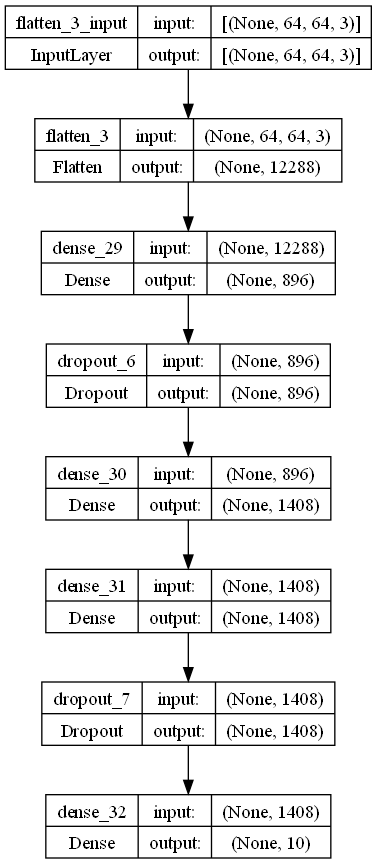

In [782]:
plot_model(best_ann_model, show_shapes=True, show_layer_names=True)

**Plot History**

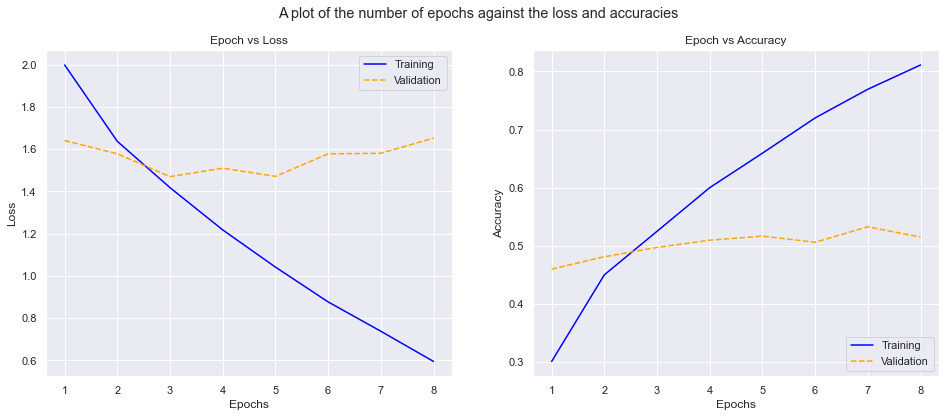

In [783]:
plot_history(best_ann_model_history)

In [784]:
get_epoch(best_ann_model_history)

The epoch with the lowest validation score is 3.
The validation loss for this epoch is 1.47.
The validation accuracy score for this epoch is 0.5


**Model Evaluation Metrics**

*Loading the best model*

In [785]:
best_ann_model = load_model("checkpoints/ann/best_model.hdf5")

*Prediction Evaluation*

In [786]:
data = [ 
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

ann_acc_pred = AccuracyPrediction(data, "neural network")
ann_target_probs, ann_target_preds = ann_acc_pred.predict(best_ann_model)

In [787]:
assert_correct_shape(ann_target_probs, data, "probability")
assert_correct_shape(ann_target_preds, data, "prediction")

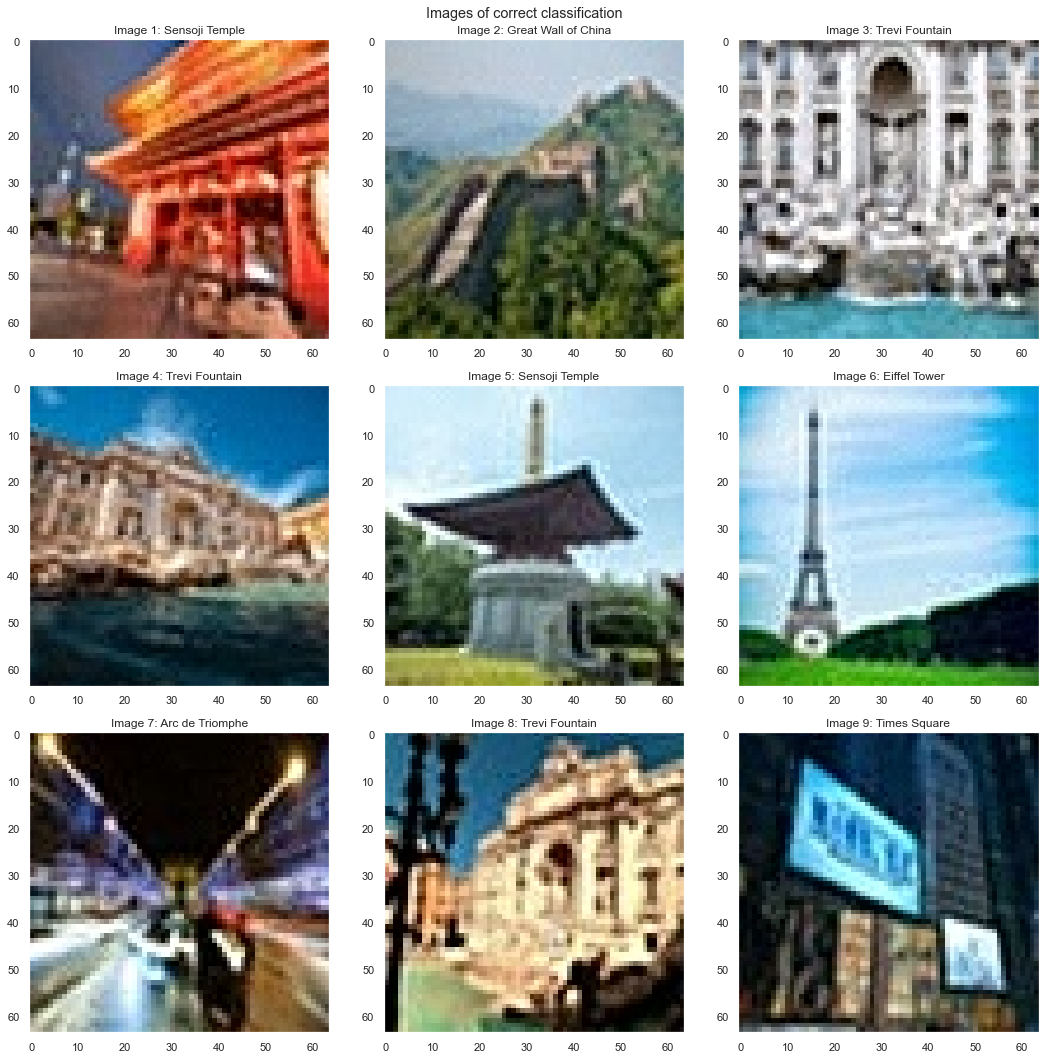

In [788]:
show_correct_images(data, ann_target_preds, "correct")

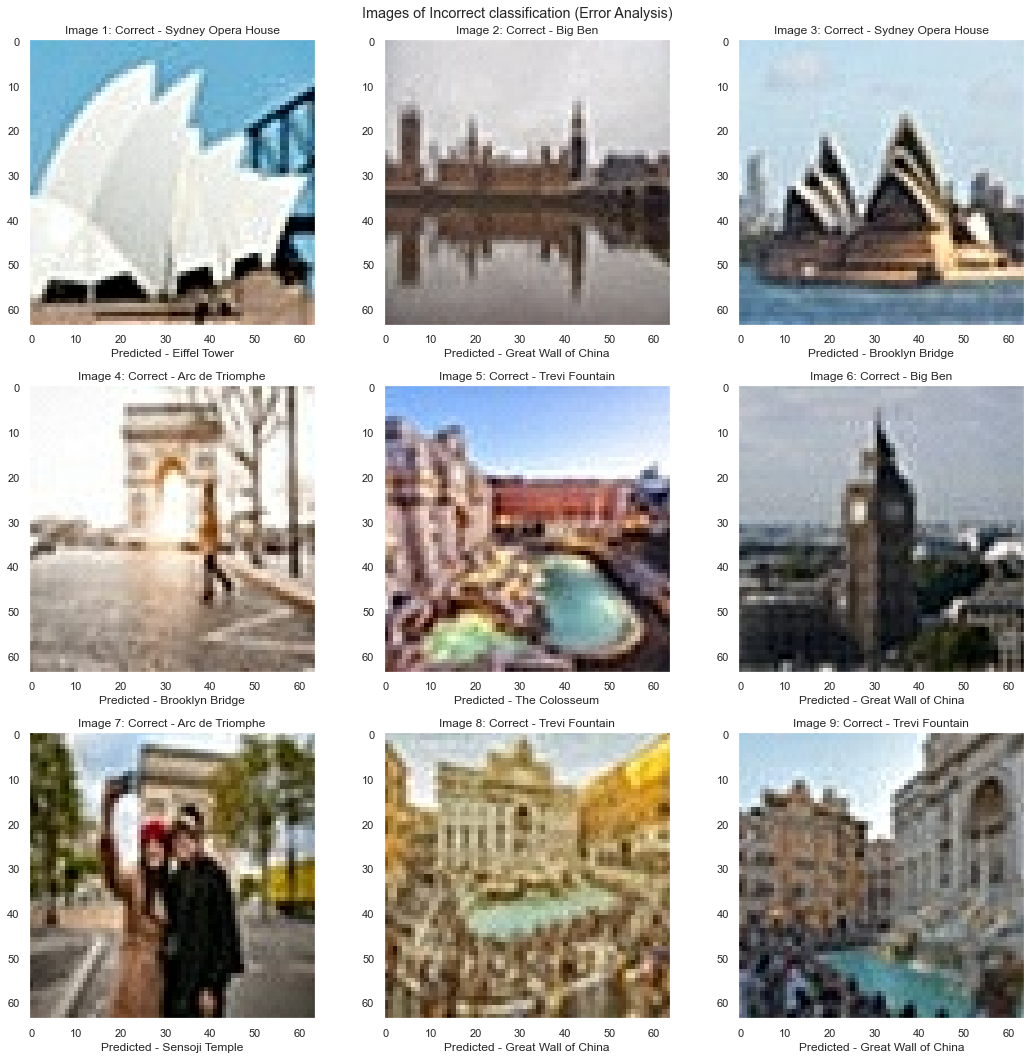

In [789]:
show_correct_images(data, ann_target_preds, "incorrect")

*Acurracy Evaluation*

In [790]:
ann_acc_pred.get_acc_loss(best_ann_model)

The loss of our training data is 1.1.
The accuracy of our training data is 0.65.
The loss of our validation data is 1.47.
The accuracy of our validation data is 0.5.
The loss of our testing data is 1.49.
The accuracy of our testing data is 0.5.


*ROC-AUC Scores*

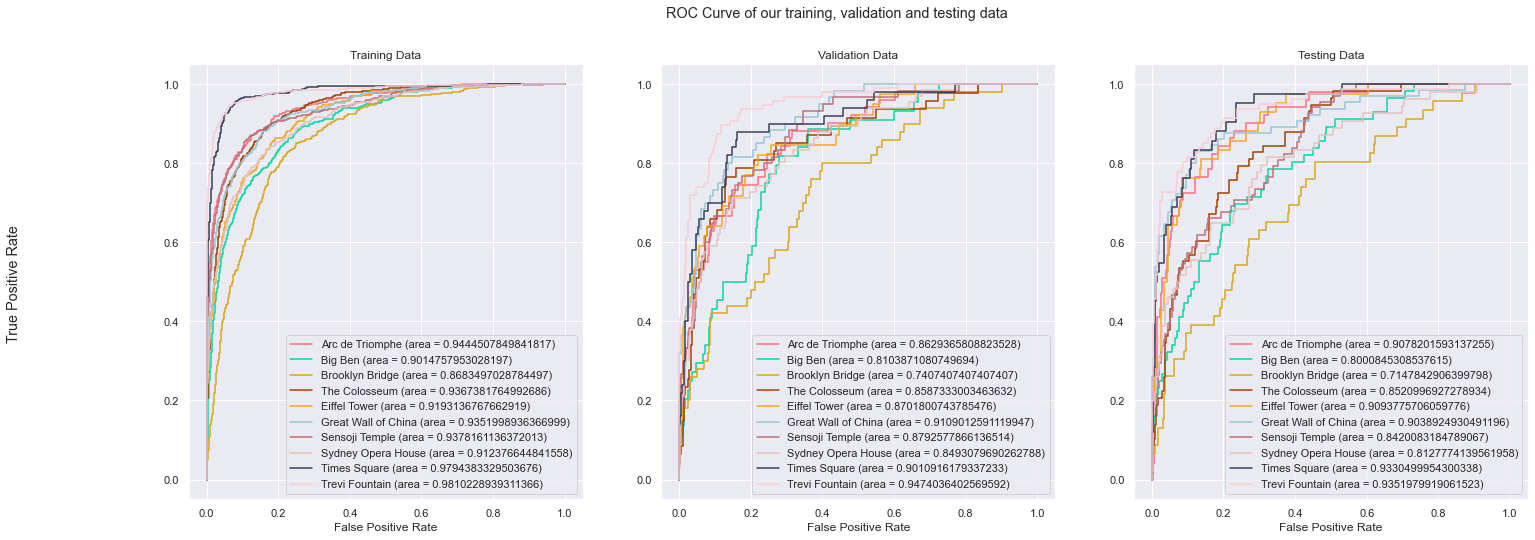

In [791]:
plot_all_curves(best_ann_model, "neural_network", data)

In [792]:
roc_auc_ann = RocAucScore(data, ann_target_probs, y_train)
roc_auc_ann.compute()

The ROC-AUC score for our training set is 0.932
The ROC-AUC score for our validation set is 0.863
The ROC-AUC score for our testing set is 0.861


*Confusion Matrix*

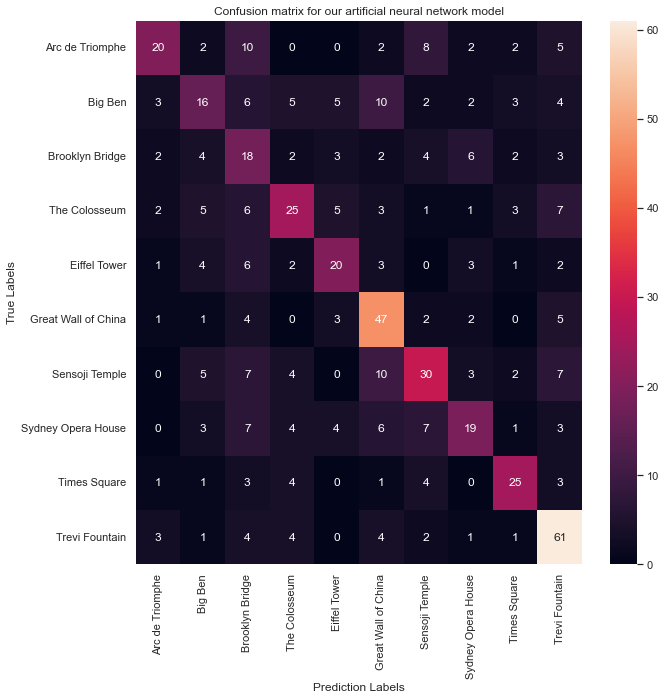

In [793]:
plot_confusion_matrix("artificial neural network", y_test, ann_target_preds)

*Classification Report*

In [794]:
print_classification_report(y_test, ann_target_preds[2])

                     precision    recall  f1-score   support

    Arc de Triomphe       0.61      0.39      0.48        51
            Big Ben       0.38      0.29      0.33        56
    Brooklyn Bridge       0.25      0.39      0.31        46
      The Colosseum       0.50      0.43      0.46        58
       Eiffel Tower       0.50      0.48      0.49        42
Great Wall of China       0.53      0.72      0.61        65
     Sensoji Temple       0.50      0.44      0.47        68
 Sydney Opera House       0.49      0.35      0.41        54
       Times Square       0.62      0.60      0.61        42
     Trevi Fountain       0.61      0.75      0.67        81

           accuracy                           0.50       563
          macro avg       0.50      0.48      0.48       563
       weighted avg       0.51      0.50      0.49       563



#### Convolutional Neural Network

##### A basic CNN

**Obtaining and normalising our image data**

In [795]:
X_train, y_train, X_val, y_val, X_test, X_test_og, y_test = normalise_flatten_data(
    train_nn, val_nn, test_nn, flatten=False
)

**Our Baseline Model**

In [796]:
from keras.layers import Conv2D, MaxPooling2D, Dropout

In [797]:
class CNNBasic(tf.keras.Model): 
    def __init__(self, dropout_rate): 
        super(CNNBasic, self).__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=3, activation="relu", name="conv1", input_shape=(64, 64, 3))
        self.maxpool1 = MaxPooling2D(pool_size=2, name="maxpool1")
        self.conv2 = Conv2D(filters=48, kernel_size=3, activation="relu", name="conv2")
        self.maxpool2 = MaxPooling2D(pool_size=2, name="maxpool2")
        self.flatten = Flatten(name="flatten")
        self.hidden1 = Dense(64, activation="relu", name="hidden1")
        self.main_output = Dense(10, activation="softmax", name="output")
    
    def call(self, input): 
        x = self.conv1(input)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.hidden1(x)
        return self.main_output(x)

In [798]:
model_fitter_cnn = ModelFitter(0.1, 0.001)
initial_functional_cnn_model = model_fitter_cnn.functional_model(CNNBasic, size=64)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/cnn/initial_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]
initial_cnn_model = model_fitter_cnn.compile(initial_functional_cnn_model)
cnn_model_history = model_fitter_cnn.fit(
    initial_cnn_model, X_train, y_train, X_val, y_val, epochs=20, callbacks=callbacks, verbose=1
)

Epoch 1/20


140/141 [============================>.] - ETA: 0s - loss: 1.9232 - accuracy: 0.3442
Epoch 1: val_loss improved from inf to 1.62027, saving model to checkpoints/cnn\initial_model.hdf5
141/141 [==============================] - 7s 47ms/step - loss: 1.9221 - accuracy: 0.3448 - val_loss: 1.6203 - val_accuracy: 0.4565
Epoch 2/20
140/141 [============================>.] - ETA: 0s - loss: 1.3963 - accuracy: 0.5371
Epoch 2: val_loss improved from 1.62027 to 1.20763, saving model to checkpoints/cnn\initial_model.hdf5
141/141 [==============================] - 6s 46ms/step - loss: 1.3953 - accuracy: 0.5371 - val_loss: 1.2076 - val_accuracy: 0.5826
Epoch 3/20
140/141 [============================>.] - ETA: 0s - loss: 1.1291 - accuracy: 0.6292
Epoch 3: val_loss improved from 1.20763 to 1.13461, saving model to checkpoints/cnn\initial_model.hdf5
141/141 [==============================] - 6s 45ms/step - loss: 1.1301 - accuracy: 0.6290 - val_loss: 1.1346 - val_accuracy: 0.6288
Epoch 4/20
140/141 [==

*Plot of Our Model*

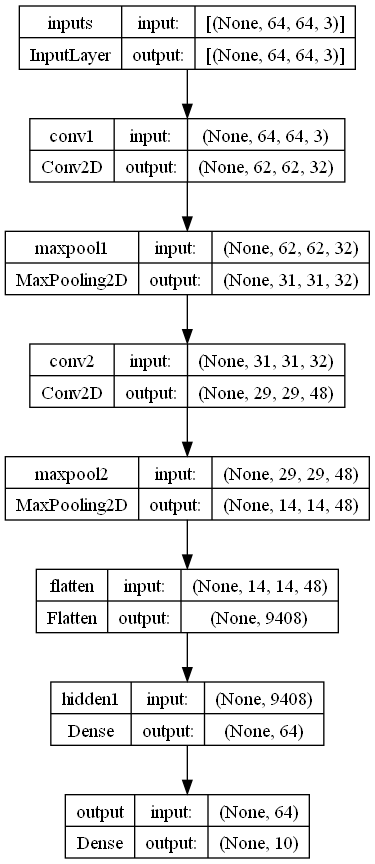

In [799]:
plot_model(initial_cnn_model, show_shapes=True, show_layer_names=True)

*Loading the best model*


In [800]:
initial_cnn_model = load_model("checkpoints/cnn/initial_model.hdf5")

*Evaluation Metrics*

In [801]:
results = initial_cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"The loss of our initial basic CNN model for our test set is {round(results[0], 2)}.")
print(f"The accuracy of our initial basic CNN model for our test set is {round(results[1], 2)}.")

The loss of our initial basic CNN model for our test set is 1.27.
The accuracy of our initial basic CNN model for our test set is 0.64.


In [802]:
initial_cnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 62, 62, 32)        896       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 48)        13872     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 48)        0         
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 hidden1 (Dense)             (None, 64)                6021

**Hyperparameter Tuning**

In [803]:
def cnn_model_builder(hp):
    model = tf.keras.Sequential()
    filter = hp.Int("initial_filter", min_value=16, max_value=128, step=16)
    kernel_size = hp.Choice("kernel_size", values=[2, 3])
    activation = hp.Choice("activation", values=["relu", "tanh"])
    model.add(
        Conv2D(
            filters=filter, kernel_size=kernel_size, activation=activation, name="conv1", input_shape=(64, 64, 3)
        )
    )
    pool_size = hp.Int("pool_size", 2, 4)
    model.add(
        MaxPooling2D(pool_size=pool_size, name="maxpool1", padding="same")
    )
    for i in range(hp.Int("num_conv", 1, 3)):
        filter = hp.Int(f"filter_{i}", min_value=16, max_value=128, step=16)
        kernel_size = hp.Choice(f"kernel_size_{i}", values=[2, 3])
        model.add(
            Conv2D(filters=filter, kernel_size=kernel_size, activation=activation,
                   padding="same", name=f"conv{i+2}")
        )
        pool_size = hp.Int("pool_size", 2, 4)
        model.add(
            MaxPooling2D(pool_size=pool_size, name=f"maxpool{i+2}", padding="same")
        )
    model.add(Flatten(name="Flatten"))
    for i in range(hp.Int("num_hidden", 1, 2)): 
        units = hp.Int(f"units_{i}", min_value=16, max_value=64, step=16)
        model.add(
            Dense(units, activation=activation)
        )
        dropout = hp.Boolean(f"dropout_{i}")
        if dropout: 
            dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
            model.add(Dropout(dropout_rate))
    model.add(Dense(units=10, activation="softmax"))
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.compile(
        loss=loss, optimizer=optimizer, metrics=["accuracy"]
    )
    return model

In [804]:
# CNN TUNER COMPLETED
cnn_tuner = kt.Hyperband(
    cnn_model_builder,
    objective="val_accuracy",
    max_epochs=15,
    factor=3,
    hyperband_iterations=2,
    directory="neural_network",
    project_name="cnn_tuning"
)

cnn_tuner.search(
    X_train, y_train, epochs=15, 
    batch_size=32, validation_data=(X_val, y_val), verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, verbose=5)]
)

INFO:tensorflow:Reloading Tuner from neural_network\cnn_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


*Our top 10 best models*

In [805]:
NUM_MODELS = 10
best_hps = cnn_tuner.get_best_hyperparameters(NUM_MODELS)
initial_filters, initial_kernel_sizes = [], []
# Convolutional Layers Section
num_conv_layers, filters_1, kernels_1, filters_2, kernels_2 = [], [], [], [], []
filters_3, kernels_3, pool_sizes = [], [], []
# Fully Connected Layers Section
num_hidden_layers, units_1, dropouts_1, units_2, dropouts_2 = [], [], [], [], []
model_numbers, activations, learning_rates = [], [], []
for i in range(NUM_MODELS): 
    num_conv_layer = best_hps[i].get("num_conv")
    num_conv_layers.append(num_conv_layer + 1)
    initial_filter = best_hps[i].get("initial_filter")
    initial_filters.append(initial_filter)
    initial_kernel = best_hps[i].get("kernel_size")
    initial_kernel_sizes.append(initial_kernel)
    for j in range(3): 
        if (j >= num_conv_layer):
            filters = np.nan
            kernel = np.nan
        else:
            filters = best_hps[i].get(f"filter_{j}")
            kernel = best_hps[i].get(f"kernel_size_{j}")
        
        if (j == 0): 
            filters_1.append(filters)
            kernels_1.append(kernel) 
        elif (j == 1): 
            filters_2.append(filters)
            kernels_2.append(kernel)
        else:
            filters_3.append(filters)
            kernels_3.append(kernel)
    
    num_hidden_layer = best_hps[i].get(f"num_hidden")
    num_hidden_layers.append(num_hidden_layer)
    for j in range(2): 
        if (j >= num_hidden_layer): 
            units = np.nan
            dropouts = np.nan
            dropout_rate = np.nan
        else: 
            units = best_hps[i].get(f"units_{j}")
            dropout_boolean = best_hps[i].get(f"dropout_{j}")
            if dropout_boolean:
                dropout = best_hps[i].get(f"dropout_rate_{j}")
            else: 
                dropout = dropout_boolean
            
        if (j == 0):
            units_1.append(units)
            dropouts_1.append(dropout)
        else: 
            units_2.append(units)
            dropouts_2.append(dropout)
    
    
    pool_size = best_hps[i].get("pool_size")
    pool_sizes.append(pool_size)
    
    activations.append(best_hps[i].get("activation"))
    learning_rates.append(best_hps[i].get("learning_rate"))
    
    accuracy_scores = [
        0.762, 0.735, 0.732, 0.726, 0.716, 0.680, 0.673, 0.668, 0.666, 0.641
    ]
    
    model_numbers.append(i + 1)
    
get_top_10_cnn_dict = {
    "Model Rank": model_numbers, 
    "Number of Conv Layers": num_conv_layers,
    "Conv. Layer 1 Filter": initial_filters,
    "Conv. Layer 1 Kernel": initial_kernel_sizes,
    "Conv. Layer 2 Filter": filters_1, 
    "Conv. Layer 2 Kernel": kernels_1,
    "Conv. Layer 3 Filter": filters_2, 
    "Conv. Layer 3 Kernel": kernels_2, 
    "Conv. Layer 4 Filter": filters_3, 
    "Conv. Layer 4 Kernel": kernels_3, 
    "Max Pooling Size": pool_sizes,
    "Number of Hidden Layers": num_hidden_layers, 
    "Hidden Layer 1": units_1, 
    "Dropout Layer 1": dropouts_1,
    "Hidden Layer 2": units_2,
    "Dropout Layer 2": dropouts_2,
    "Activation": activations, 
    "Learning Rate": learning_rates,
    "Accuracy Scores": accuracy_scores
}
get_top_10_cnn_df = pd.DataFrame(data=get_top_10_cnn_dict)
get_top_10_cnn_df

Model Rank  Number of Conv Layers  Conv. Layer 1 Filter  \
0           1                      3                    64   
1           2                      3                    32   
2           3                      3                    80   
3           4                      3                   112   
4           5                      4                   128   
5           6                      4                    48   
6           7                      3                    64   
7           8                      4                    96   
8           9                      3                    16   
9          10                      4                   128   

   Conv. Layer 1 Kernel  Conv. Layer 2 Filter  Conv. Layer 2 Kernel  \
0                     2                    32                     2   
1                     3                   128                     2   
2                     2                    48                     2   
3                     2                    32                     2   
4                     2                    64                     2   
5                     2                    48                     3   
6                     2                    32                     2   
7                     2                    96                     3   
8                     3                    64                     3   
9                     2                    64                     2   

   Conv. Layer 3 Filter  Conv. Layer 3 Kernel  Conv. Layer 4 Filter  \
0                    96                     3                   NaN   
1                   112                     2                   NaN   
2                    32                     2                   NaN   
3                    96                     3                   NaN   
4                    64                     2                  64.0   
5                    16                     3                 128.0   
6                    96                     3                   NaN   
7                    96                     2                  16.0   
8                    16                     2                   NaN   
9                    64                     2                  64.0   

   Conv. Layer 4 Kernel  Max Pooling Size  Number of Hidden Layers  \
0                   NaN                 3                        1   
1                   NaN                 4                        1   
2                   NaN                 3                        2   
3                   NaN                 2                        2   
4                   2.0                 2                        2   
5                   3.0                 3                        2   
6                   NaN                 3                        1   
7                   2.0                 3                        1   
8                   NaN                 3                        1   
9                   2.0                 2                        2   

   Hidden Layer 1 Dropout Layer 1  Hidden Layer 2 Dropout Layer 2 Activation  \
0              64           False             NaN           False       tanh   
1              64             0.5             NaN             0.5       relu   
2              64           False            48.0             0.2       tanh   
3              48           False            64.0             0.2       relu   
4              64             0.5            48.0           False       tanh   
5              16             0.1            16.0             0.1       tanh   
6              64           False             NaN           False       tanh   
7              32           False             NaN           False       relu   
8              16           False             NaN           False       relu   
9              64             0.5            48.0           False       tanh   

   Learning Rate  Accuracy Scores  
0          0.001            0.762  
1          0.001            0.73

**Our best model**

*Training our model*

In [806]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/cnn/best_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]

In [807]:
best_hps = cnn_tuner.get_best_hyperparameters(1)
best_cnn_model = cnn_model_builder(best_hps[0])
best_cnn_model_history = best_cnn_model.fit(
    X_train, y_train, batch_size=32, callbacks=callbacks,
    validation_data=(X_val, y_val), verbose=1, epochs=20
)

Epoch 1/20


141/141 [==============================] - ETA: 0s - loss: 1.8078 - accuracy: 0.3726
Epoch 1: val_loss improved from inf to 1.46104, saving model to checkpoints/cnn\best_model.hdf5
141/141 [==============================] - 7s 49ms/step - loss: 1.8078 - accuracy: 0.3726 - val_loss: 1.4610 - val_accuracy: 0.4920
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 1.3923 - accuracy: 0.5295
Epoch 2: val_loss improved from 1.46104 to 1.20722, saving model to checkpoints/cnn\best_model.hdf5
141/141 [==============================] - 7s 48ms/step - loss: 1.3923 - accuracy: 0.5295 - val_loss: 1.2072 - val_accuracy: 0.5879
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 1.2064 - accuracy: 0.6015
Epoch 3: val_loss did not improve from 1.20722
141/141 [==============================] - 7s 48ms/step - loss: 1.2064 - accuracy: 0.6015 - val_loss: 1.2363 - val_accuracy: 0.5737
Epoch 4/20
141/141 [==============================] - ETA: 0s - loss: 1.0515 - accur

*Our model architecture*

<u>A summary of our model</u>

In [808]:
best_cnn_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 63, 63, 64)        832       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 21, 21, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 21, 21, 32)        8224      
                                                                 
 maxpool2 (MaxPooling2D)     (None, 7, 7, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 96)          27744     
                                                                 
 maxpool3 (MaxPooling2D)     (None, 3, 3, 96)          0         
                                                                 
 Flatten (Flatten)           (None, 864)             

<u>A plot of our model</u>

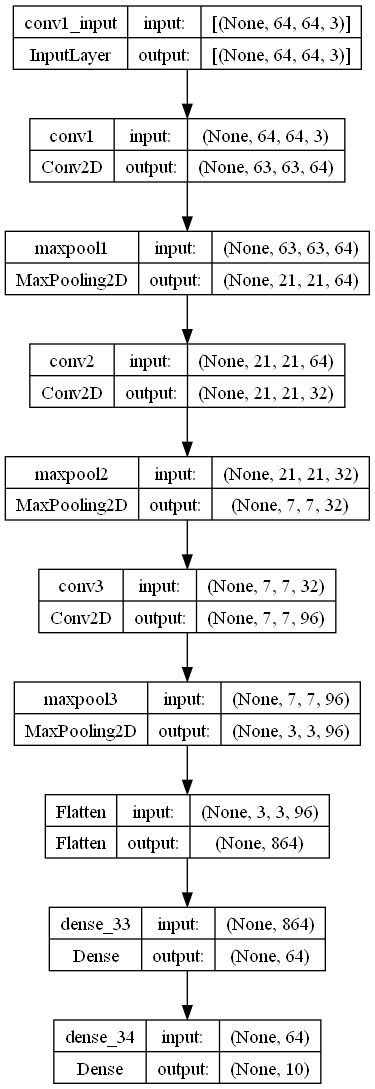

In [809]:
plot_model(best_cnn_model, show_shapes=True, show_layer_names=True)

<u>Plot History</u>

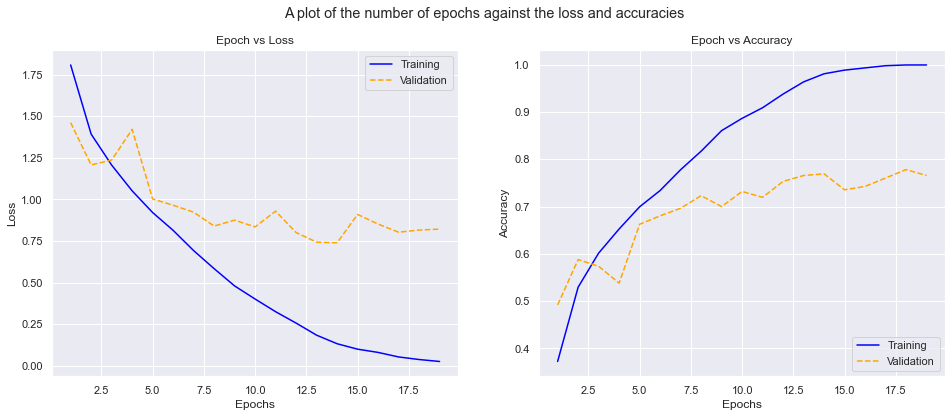

In [810]:
plot_history(best_cnn_model_history)

In [811]:
get_epoch(best_cnn_model_history)

The epoch with the lowest validation score is 14.
The validation loss for this epoch is 0.74.
The validation accuracy score for this epoch is 0.77


*Model Evaluation Metrics*

<u>Loading the best model</u>

In [812]:
best_cnn_model = load_model("checkpoints/cnn/best_model.hdf5")

<u>Prediction Evaluation</u>

In [813]:
data = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

cnn_acc_pred = AccuracyPrediction(data, "neural network")
cnn_target_probs, cnn_target_preds = cnn_acc_pred.predict(best_cnn_model)

In [814]:
assert_correct_shape(cnn_target_probs, data, "probability")
assert_correct_shape(cnn_target_preds, data, "prediction")

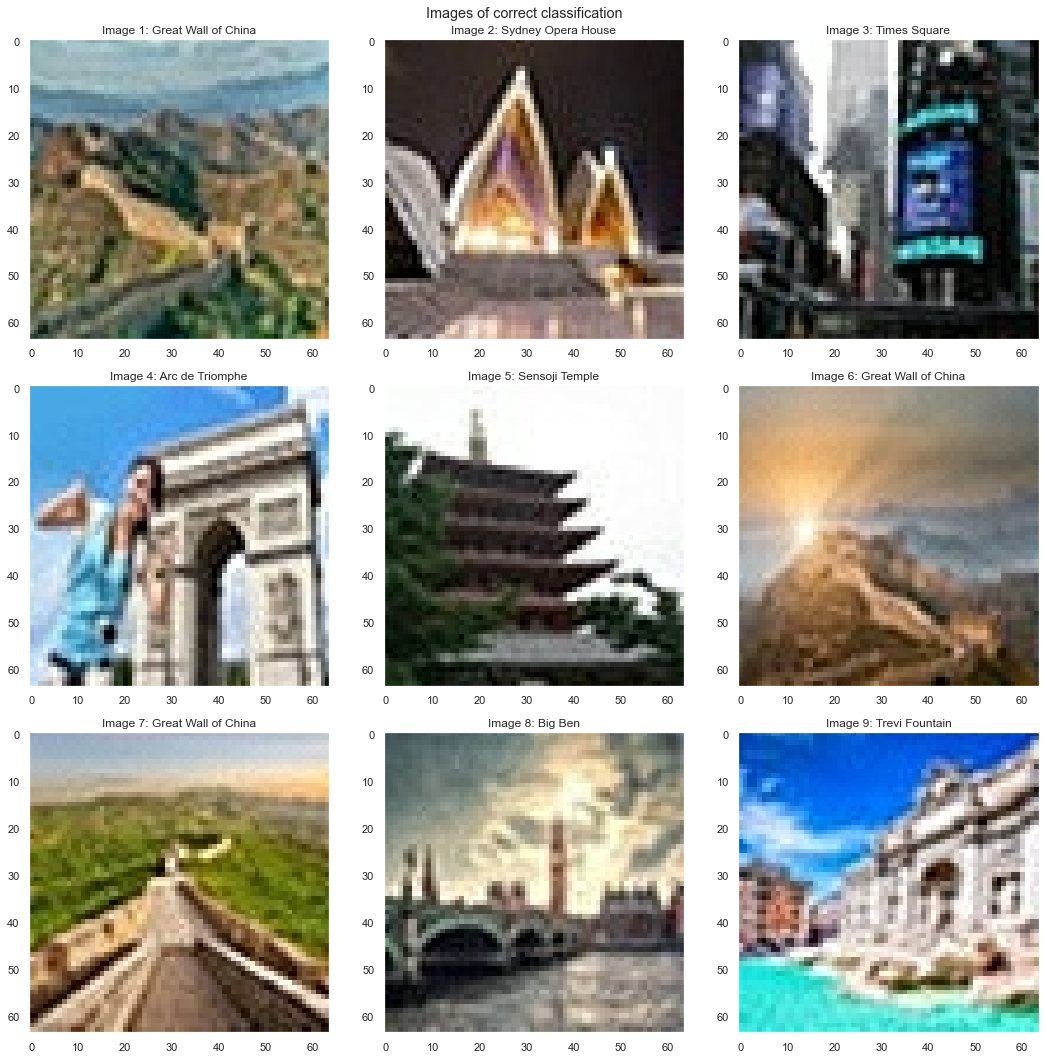

In [815]:
show_correct_images(data, cnn_target_preds, "correct")

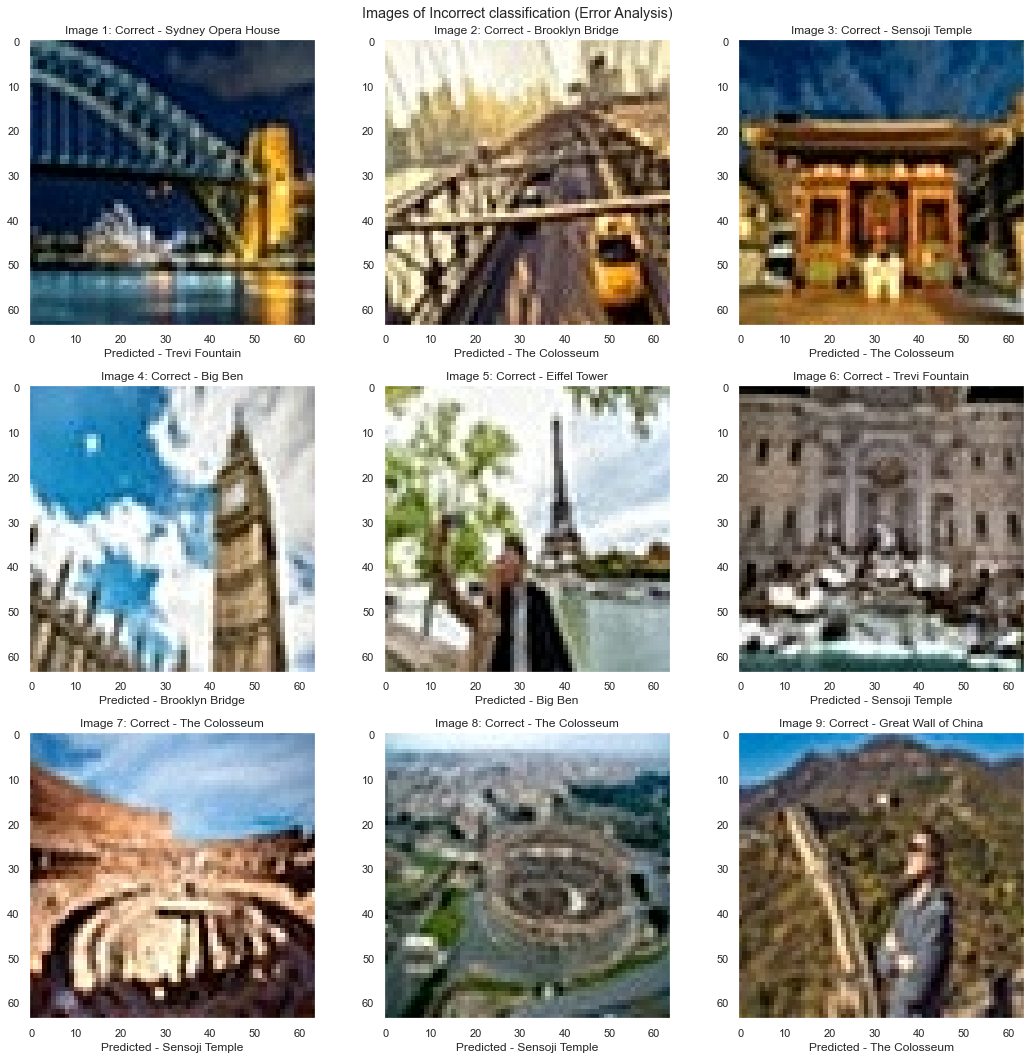

In [816]:
show_correct_images(data, cnn_target_preds, "incorrect")

<u>Accuracy Evaluation</u>

In [817]:
cnn_acc_pred.get_acc_loss(best_cnn_model)

The loss of our training data is 0.1.
The accuracy of our training data is 0.99.
The loss of our validation data is 0.74.
The accuracy of our validation data is 0.77.
The loss of our testing data is 0.82.
The accuracy of our testing data is 0.77.


<u>ROC-AUC Scores</u>

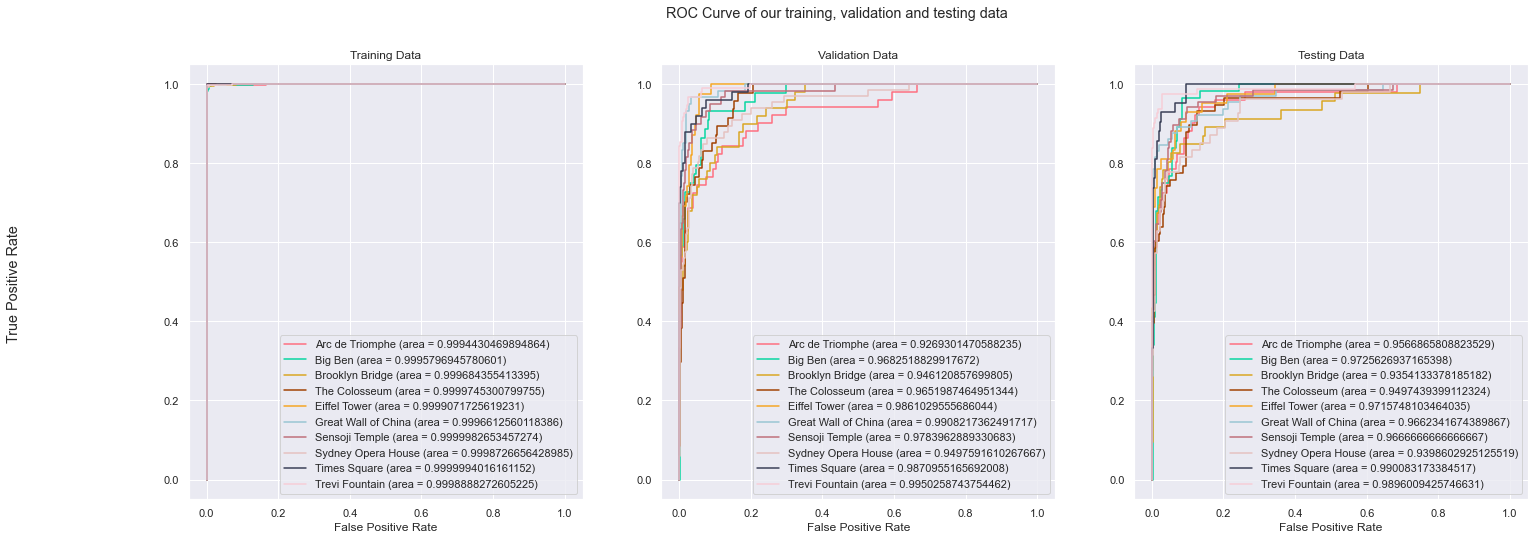

In [818]:
plot_all_curves(best_cnn_model, "neural_network", data)

In [819]:
roc_auc_ann = RocAucScore(data, cnn_target_probs, y_train)
roc_auc_ann.compute()

The ROC-AUC score for our training set is 1.0
The ROC-AUC score for our validation set is 0.969
The ROC-AUC score for our testing set is 0.964


<u>Confusion Matrix</u>

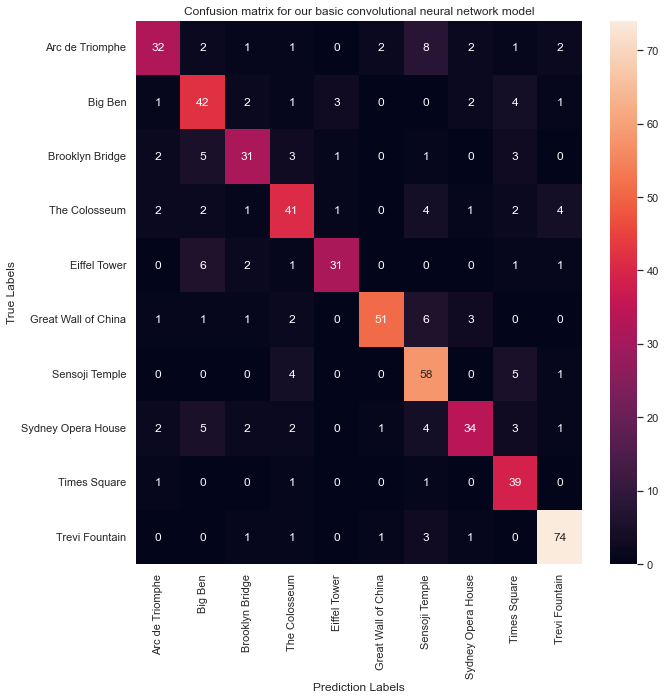

In [820]:
plot_confusion_matrix("basic convolutional neural network", y_test, cnn_target_preds)

<u>Classification Report</u>

In [821]:
print_classification_report(y_test, cnn_target_preds[2])

                     precision    recall  f1-score   support

    Arc de Triomphe       0.78      0.63      0.70        51
            Big Ben       0.67      0.75      0.71        56
    Brooklyn Bridge       0.76      0.67      0.71        46
      The Colosseum       0.72      0.71      0.71        58
       Eiffel Tower       0.86      0.74      0.79        42
Great Wall of China       0.93      0.78      0.85        65
     Sensoji Temple       0.68      0.85      0.76        68
 Sydney Opera House       0.79      0.63      0.70        54
       Times Square       0.67      0.93      0.78        42
     Trevi Fountain       0.88      0.91      0.90        81

           accuracy                           0.77       563
          macro avg       0.77      0.76      0.76       563
       weighted avg       0.78      0.77      0.77       563



##### The AlexNet Model

**Obtaining and normalising our image data**

In [878]:
X_train, y_train, X_val, y_val, X_test, X_test_og, y_test = normalise_flatten_data(
    train_alexnet, val_alexnet, test_alexnet, flatten=False
)

**Our Baseline Model**

In [879]:
class AlexNetNeuralNetwork():
    def __init__(self, dropout_rate):
        super(AlexNetNeuralNetwork, self).__init__()
        self.conv1 = Conv2D(
            filters=64, kernel_size=(3, 3), strides=(4, 4), activation="relu",
            input_shape=(227, 227, 3), name="conv1"
        )
        self.maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool1")
        self.conv2 = Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation="relu", name="conv2")
        self.maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool2")
        self.conv3 = Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu", name="conv3")
        self.conv4 = Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu", name="conv4")
        self.conv5 = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu", name="conv5")
        self.maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool3")
        self.flatten = Flatten(name="flatten")
        self.hidden = Dense(1000, activation="relu", name="hidden")
        self.dropout = Dropout(dropout_rate, name="dropout")
        self.main_output = Dense(10, activation="softmax", name="output")
    
    def call(self, input): 
        x = self.conv1(input)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.dropout(x)
        return self.main_output(x)

In [880]:
model_fitter_alexnet = ModelFitter(0.1, 0.001)
initial_functional_alexnet_model = model_fitter_alexnet.functional_model(AlexNetNeuralNetwork, size=227)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/alexnet/initial_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]
initial_alexnet_model = model_fitter_alexnet.compile(initial_functional_alexnet_model)
alexnet_model_history = model_fitter_alexnet.fit(
    initial_alexnet_model, X_train, y_train, X_val, y_val, epochs=20, callbacks=callbacks, verbose=1
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 2.2754 - accuracy: 0.1652
Epoch 1: val_loss improved from inf to 2.12785, saving model to checkpoints/alexnet\initial_model.hdf5
141/141 [==============================] - 80s 564ms/step - loss: 2.2754 - accuracy: 0.1652 - val_loss: 2.1279 - val_accuracy: 0.2877
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 2.0026 - accuracy: 0.2973
Epoch 2: val_loss improved from 2.12785 to 1.80551, saving model to checkpoints/alexnet\initial_model.hdf5
141/141 [==============================] - 79s 563ms/step - loss: 2.0026 - accuracy: 0.2973 - val_loss: 1.8055 - val_accuracy: 0.4156
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 1.7332 - accuracy: 0.4016
Epoch 3: val_loss improved from 1.80551 to 1.49511, saving model to checkpoints/alexnet\initial_model.hdf5
141/141 [==============================] - 76s 537ms/step - loss: 1.7332 - accuracy: 0.4016 - val_loss: 1.4951 - val_accuracy: 

*Plot of our model*

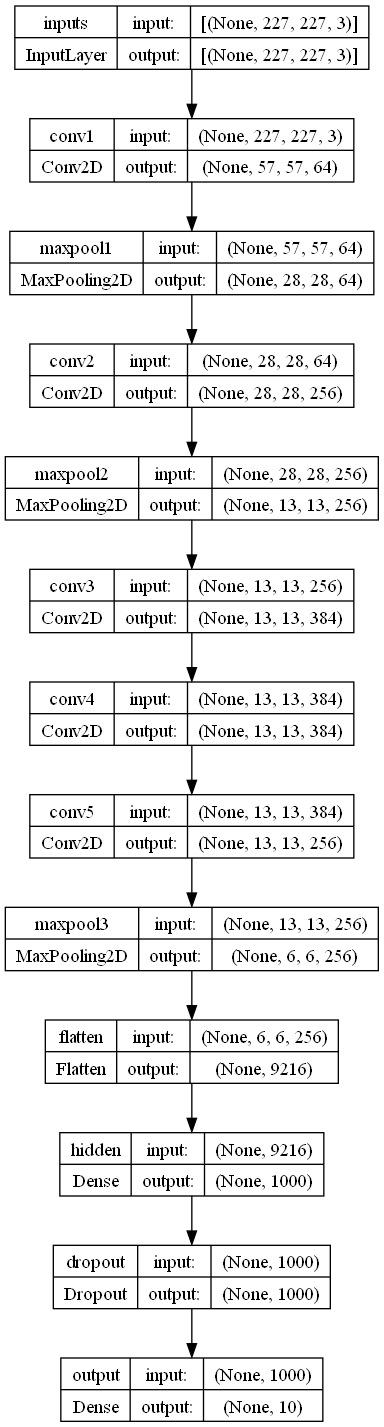

In [881]:
plot_model(initial_alexnet_model, show_shapes=True, show_layer_names=True)

*Loading the best model*

In [826]:
initial_alexnet_model = load_model("checkpoints/alexnet/initial_model.hdf5")

*Evaluation Metrics*

In [895]:
results = initial_alexnet_model.evaluate(X_test, y_test, verbose=0)
print(f"The loss of our initial basic alexnet model for our test set is {round(results[0], 2)}.")
print(f"The accuracy of our initial basic alexnet model for our test set is {round(results[1], 2)}.")

The loss of our initial basic alexnet model for our test set is 1.09.
The accuracy of our initial basic alexnet model for our test set is 0.69.


**Hyperparameter tuning**

In [828]:
def alexnet_model_builder(hp):
    model = tf.keras.Sequential()
    model.add(
        Conv2D(
            filters=64, kernel_size=(3, 3), strides=(4, 4), activation="relu",
            input_shape=(227, 227, 3), name="conv1"
        )
    )
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool1"))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation="relu", name="conv2"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool2"))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu", name="conv3"))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu", name="conv4"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu", name="conv5"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name="maxpool3"))
    model.add(Flatten(name="flatten"))
    for i in range(hp.Int("num_hidden_layers", 1, 3)):
        no_units = hp.Int(f"units_{i}", min_value=128, max_value=1280, step=64)
        model.add(Dense(units=no_units, activation="relu"))
        dropout = hp.Boolean(f"dropout_{i}")
        if dropout: 
            dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
            model.add(
                Dropout(dropout_rate, name=f"dropout{i}")
            )    
    model.add(Dense(10, activation="softmax"))

    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    # Setting up the optimizer and the learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.compile(
        loss=loss, optimizer=optimizer, metrics=["accuracy"]
    )
    return model

In [829]:
alexnet_tuner = kt.RandomSearch(
    alexnet_model_builder,
    objective="val_accuracy",
    seed=2,
    max_trials=10,
    directory="neural_network",
    project_name="alexnet_tuning"
)

alexnet_tuner.search(
    X_train, y_train, epochs=10, 
    batch_size=32, validation_data=(X_val, y_val), verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, verbose=5)]
)

INFO:tensorflow:Reloading Tuner from neural_network\alexnet_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


*Our Top 3 best models*

In [830]:
NUM_MODELS = 3
best_hps = alexnet_tuner.get_best_hyperparameters(NUM_MODELS)
model_numbers, num_layers, learning_rates = [], [], []
layer_1, layer_2, layer_3 = [], [], []
dropout_1, dropout_2, dropout_3 = [], [], []
for i in range(NUM_MODELS): 
    model_numbers.append(i + 1)
    num_layer = best_hps[i].get("num_hidden_layers")
    num_layers.append(num_layer)
    learning_rate = best_hps[i].get("learning_rate")
    learning_rates.append(learning_rate)
    
    for j in range(3):
        if (j >= num_layer): 
            units = np.nan
            dropout = np.nan
        else: 
            units = best_hps[i].get(f"units_{j}")
            dropout_boolean = best_hps[i].get(f"dropout_{j}")
            if (dropout_boolean): 
                dropout = best_hps[i].get(f"dropout_rate_{j}")
            else: 
                dropout = dropout_boolean
        if (j == 0):
            layer_1.append(units)
            dropout_1.append(dropout)
        elif (j == 1):
            layer_2.append(units)
            dropout_2.append(dropout)
        else:
            layer_3.append(units)
            dropout_3.append(dropout)
get_top_3_alexnet_dict = { 
    "Model Rank": model_numbers,
    "Number of Hidden Layers": num_layers,
    "Hidden Layer 1": layer_1,
    "Dropout Layer 1": dropout_1, 
    "Hidden Layer 2": layer_2,    
    "Dropout Layer 2": dropout_2, 
    "Hidden Layer 3": layer_3, 
    "Dropout Layer 3": dropout_3,
    "Learning Rate": learning_rates,
    "Accuracy Scores": [0.741, 0.737, 0.732]                      
}
get_top_3_alexnet_df = pd.DataFrame(data=get_top_3_alexnet_dict)
get_top_3_alexnet_df

Model Rank  Number of Hidden Layers  Hidden Layer 1 Dropout Layer 1  \
0           1                        1            1088           False   
1           2                        3            1216             0.1   
2           3                        2             896           False   

   Hidden Layer 2  Dropout Layer 2  Hidden Layer 3  Dropout Layer 3  \
0             NaN              NaN             NaN              NaN   
1          1024.0              0.1           256.0              0.1   
2           448.0              0.3             NaN              NaN   

   Learning Rate  Accuracy Scores  
0         0.0001            0.741  
1         0.0001            0.737  
2         0.0001            0.732

**Our best model**

*Training our model*

In [882]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/alexnet/best_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]

In [883]:
best_hps = alexnet_tuner.get_best_hyperparameters(1)
best_alexnet_model = alexnet_model_builder(best_hps[0])
best_alexnet_model_history = best_alexnet_model.fit(
    X_train, y_train, batch_size=32, callbacks=callbacks,
    validation_data=(X_val, y_val), verbose=1, epochs=20
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 2.0314 - accuracy: 0.2764
Epoch 1: val_loss improved from inf to 1.67888, saving model to checkpoints/alexnet\best_model.hdf5
141/141 [==============================] - 96s 672ms/step - loss: 2.0314 - accuracy: 0.2764 - val_loss: 1.6789 - val_accuracy: 0.4423
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 1.6219 - accuracy: 0.4496
Epoch 2: val_loss improved from 1.67888 to 1.47051, saving model to checkpoints/alexnet\best_model.hdf5
141/141 [==============================] - 89s 632ms/step - loss: 1.6219 - accuracy: 0.4496 - val_loss: 1.4705 - val_accuracy: 0.5009
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 1.4008 - accuracy: 0.5295
Epoch 3: val_loss improved from 1.47051 to 1.21575, saving model to checkpoints/alexnet\best_model.hdf5
141/141 [==============================] - 86s 613ms/step - loss: 1.4008 - accuracy: 0.5295 - val_loss: 1.2157 - val_accuracy: 0.5915
Ep

*Our model architecture*

<u>A summary of our model</u>

In [833]:
best_alexnet_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 57, 57, 64)        1792      
                                                                 
 maxpool1 (MaxPooling2D)     (None, 28, 28, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 256)       409856    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 13, 13, 256)       0         
                                                                 
 conv3 (Conv2D)              (None, 13, 13, 384)       885120    
                                                                 
 conv4 (Conv2D)              (None, 13, 13, 384)       1327488   
                                                                 
 conv5 (Conv2D)              (None, 13, 13, 256)     

<u>A plot of our model</u>

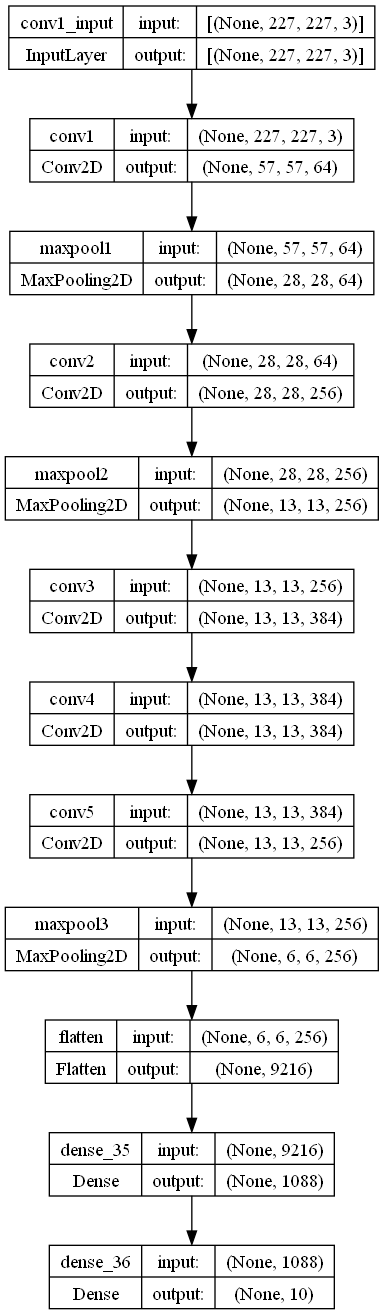

In [834]:
plot_model(best_alexnet_model, show_shapes=True, show_layer_names=True)

<u>Plot History</u>

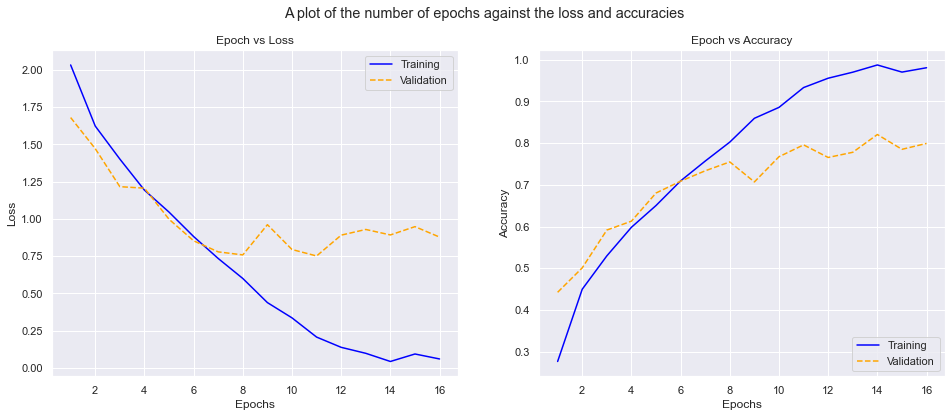

In [884]:
plot_history(best_alexnet_model_history)

In [885]:
get_epoch(best_alexnet_model_history)

The epoch with the lowest validation score is 11.
The validation loss for this epoch is 0.75.
The validation accuracy score for this epoch is 0.8


*Model Evaluation Metrics*

<u>Loading the best model</u>

In [886]:
best_alexnet_model = load_model("checkpoints/alexnet/best_model.hdf5")

<u>Prediction Evaluation</u>

In [887]:
data = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

alexnet_acc_pred = AccuracyPrediction(data, "neural network")
alexnet_target_probs, alexnet_target_preds = alexnet_acc_pred.predict(best_alexnet_model)

In [888]:
assert_correct_shape(alexnet_target_probs, data, "probability")
assert_correct_shape(alexnet_target_preds, data, "prediction")

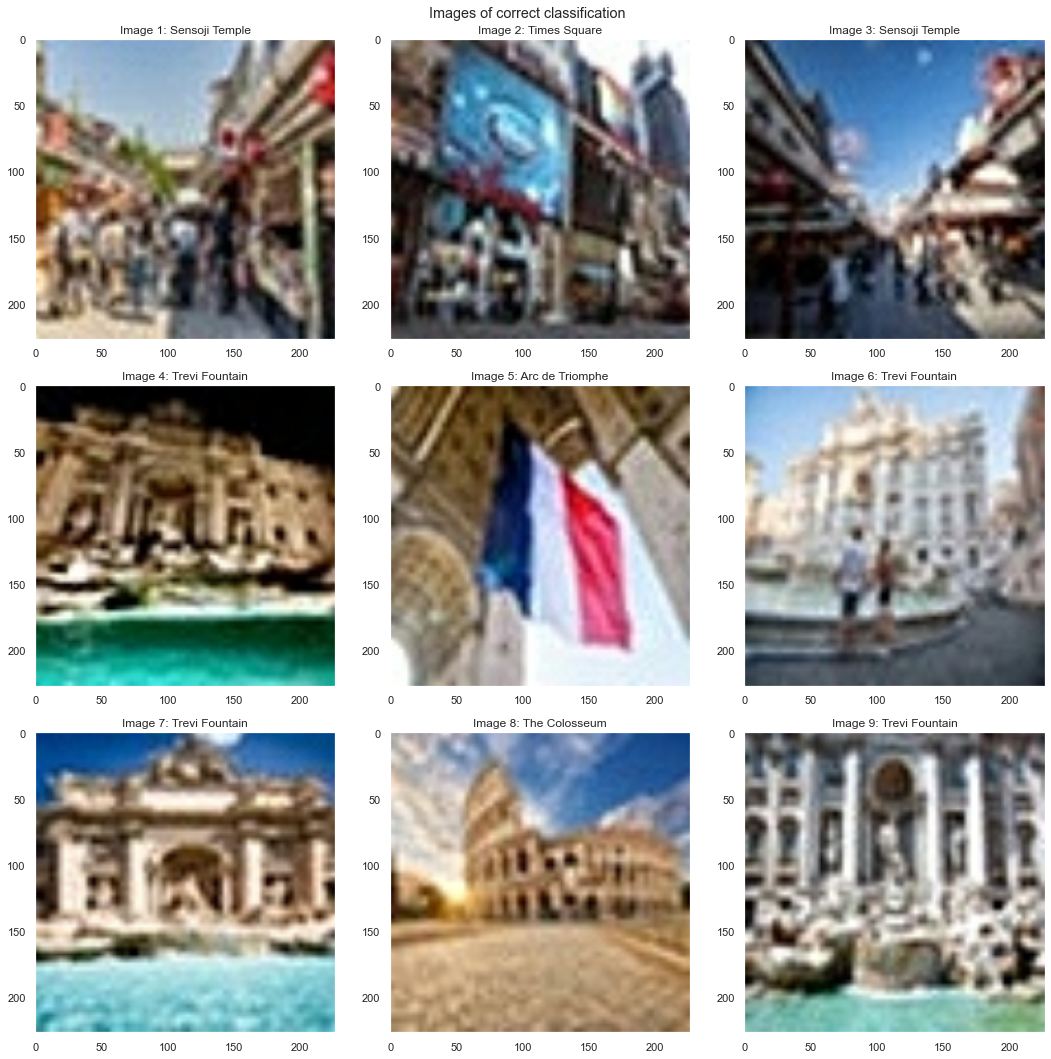

In [890]:
show_correct_images(data, alexnet_target_preds, "correct")

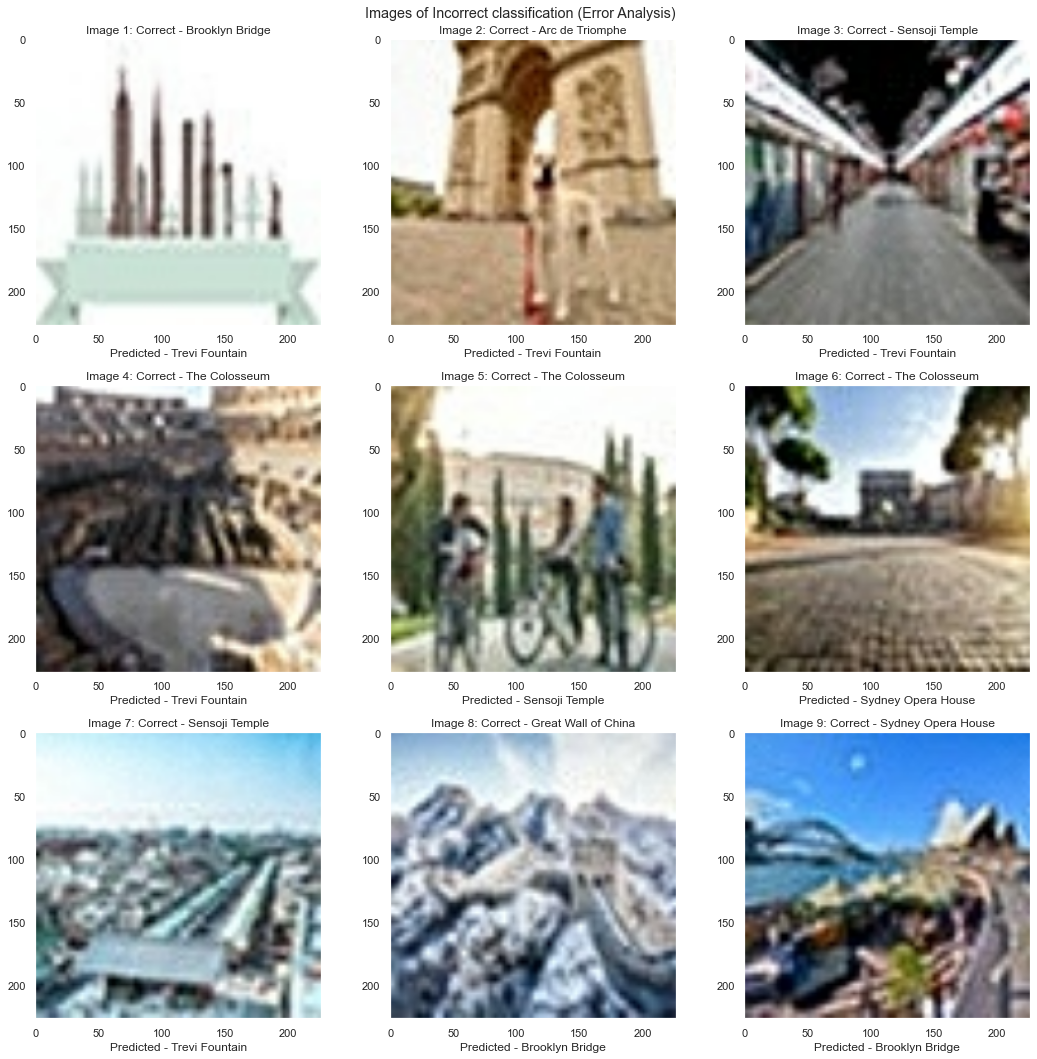

In [891]:
show_correct_images(data, alexnet_target_preds, "incorrect")

<u>Accuracy Evaluation</u>

In [892]:
alexnet_acc_pred.get_acc_loss(best_alexnet_model)

The loss of our training data is 0.08.
The accuracy of our training data is 0.98.
The loss of our validation data is 0.75.
The accuracy of our validation data is 0.8.
The loss of our testing data is 0.83.
The accuracy of our testing data is 0.79.


<u>ROC-AUC Scores</u>

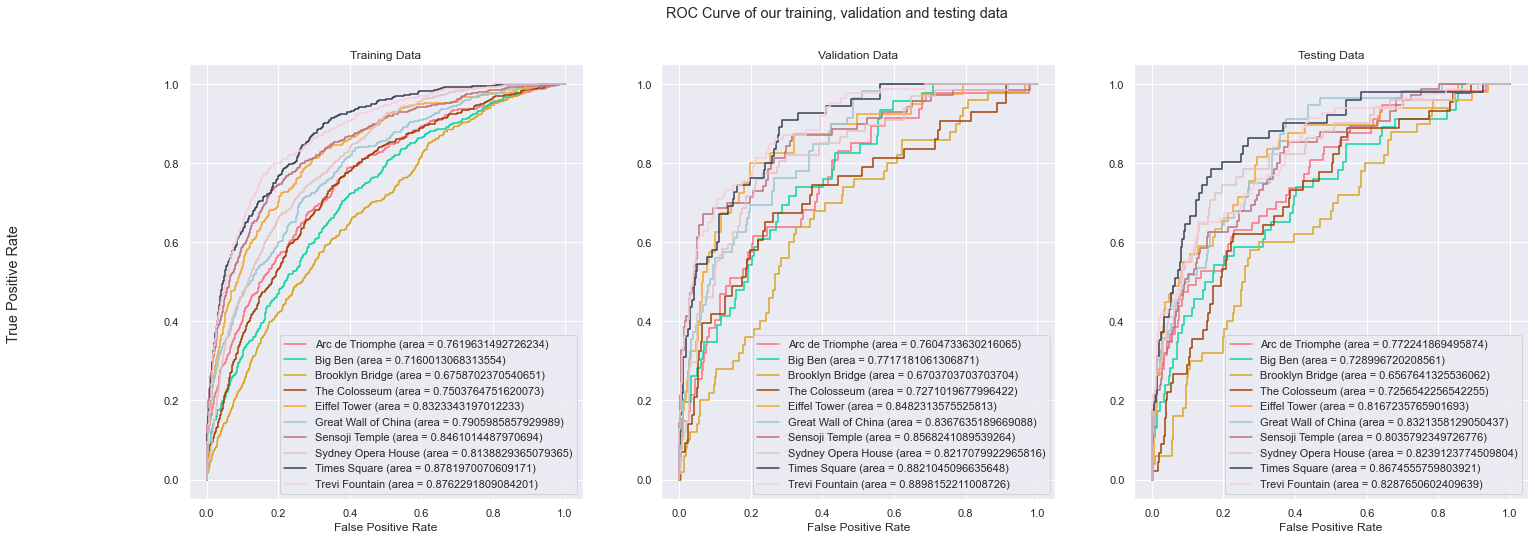

In [843]:
plot_all_curves(best_alexnet_model, "neural_network", data)

In [893]:
roc_auc_alexnet = RocAucScore(data, alexnet_target_probs, y_train)
roc_auc_alexnet.compute()

The ROC-AUC score for our training set is 1.0
The ROC-AUC score for our validation set is 0.974
The ROC-AUC score for our testing set is 0.972


<u>Confusion Matrix</u>

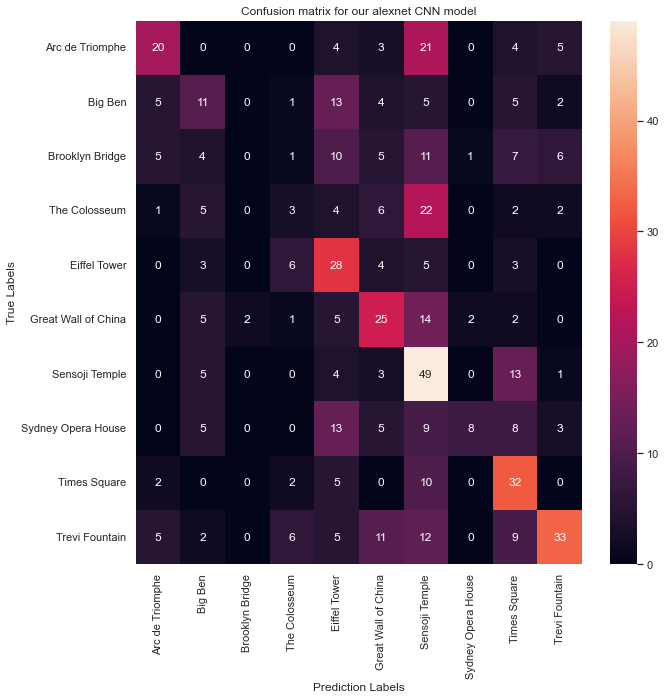

In [845]:
plot_confusion_matrix("alexnet CNN", y_test, alexnet_target_preds)

<u>Classification Report</u>

In [894]:
print_classification_report(y_test, alexnet_target_preds[2])

                     precision    recall  f1-score   support

    Arc de Triomphe       0.87      0.81      0.84        57
            Big Ben       0.62      0.65      0.64        46
    Brooklyn Bridge       0.63      0.82      0.71        50
      The Colosseum       0.82      0.73      0.78        45
       Eiffel Tower       0.83      0.78      0.80        49
Great Wall of China       0.93      0.75      0.83        56
     Sensoji Temple       0.78      0.81      0.80        75
 Sydney Opera House       0.75      0.75      0.75        51
       Times Square       0.91      0.82      0.87        51
     Trevi Fountain       0.78      0.86      0.82        83

           accuracy                           0.79       563
          macro avg       0.79      0.78      0.78       563
       weighted avg       0.80      0.79      0.79       563



##### VGG-16

**Obtaining and normalising our image data**

In [847]:
X_train, y_train, X_val, y_val, X_test, X_test_og, y_test = normalise_flatten_data(
    train_nn, val_nn, test_nn, flatten=False
)

**A look of the VGG16 Convolutional Base**

In [848]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [849]:
print(f"The number of layers in our base model is: {len(conv_base.layers)}")

The number of layers in our base model is: 19


**Our Base Model**

In [850]:
from keras.applications.vgg16 import VGG16

In [851]:
class VGG16Model(tf.keras.Model): 
    def __init__(self, dropout_rate): 
        super(VGG16Model, self).__init__()
        self.conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
        self.conv_base.trainable = False
        self.flatten = tf.keras.layers.Flatten(name="flatten")
        self.hidden1 = tf.keras.layers.Dense(3200, activation="relu", name="hidden_1")
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate, name="dropout_1")
        self.hidden2 = tf.keras.layers.Dense(1200, activation="relu", name="hidden_2")
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate, name="dropout_2")
        self.hidden3 = tf.keras.layers.Dense(128, activation="relu", name="hidden_3")
        self.main_output = tf.keras.layers.Dense(10, activation="softmax", name="output")
    
    def call(self, input): 
        x = self.conv_base(input)
        x = self.flatten(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.hidden2(x)
        x = self.dropout2(x)
        x = self.hidden3(x)
        return self.main_output(x)

In [852]:
model_fitter_vgg = ModelFitter(0.1, 0.001)
initial_functional_vgg_model = model_fitter_vgg.functional_model(VGG16Model, 64)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/vgg16/initial_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]
initial_vgg_model = model_fitter_vgg.compile(initial_functional_vgg_model)
vgg_model_history = model_fitter_vgg.fit(
    initial_vgg_model, X_train, y_train, X_val, y_val, epochs=20, callbacks=callbacks, verbose=1
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.5642
Epoch 1: val_loss improved from inf to 0.92210, saving model to checkpoints/vgg16\initial_model.hdf5
141/141 [==============================] - 37s 240ms/step - loss: 1.3181 - accuracy: 0.5642 - val_loss: 0.9221 - val_accuracy: 0.7407
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.7471
Epoch 2: val_loss improved from 0.92210 to 0.85641, saving model to checkpoints/vgg16\initial_model.hdf5
141/141 [==============================] - 34s 244ms/step - loss: 0.7627 - accuracy: 0.7471 - val_loss: 0.8564 - val_accuracy: 0.7300
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.8217
Epoch 3: val_loss improved from 0.85641 to 0.69285, saving model to checkpoints/vgg16\initial_model.hdf5
141/141 [==============================] - 35s 248ms/step - loss: 0.5413 - accuracy: 0.8217 - val_loss: 0.6929 - val_accuracy: 0.7780

*Plot of our model*

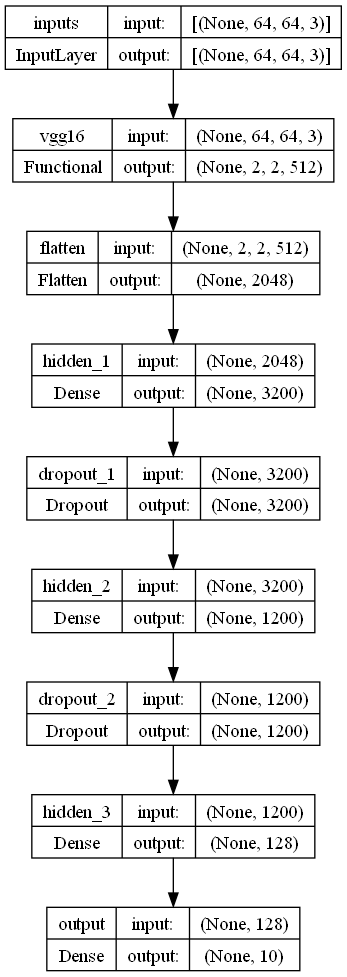

In [853]:
plot_model(initial_vgg_model, show_shapes=True, show_layer_names=True)

*Loading the best model*

In [854]:
initial_vgg_model = load_model("checkpoints/vgg16/initial_model.hdf5")

*Evaluation metrics*

In [855]:
results = initial_vgg_model.evaluate(X_test, y_test, verbose=0)
print(f"The loss of our initial VGG model for our test set is {round(results[0], 2)}.")
print(f"The accuracy of our initial VGG model for our test set is {round(results[1], 2)}.")

The loss of our initial VGG model for our test set is 0.62.
The accuracy of our initial VGG model for our test set is 0.82.


**Hyperparameter Tuning**

In [856]:
def vgg_model_builder(hp):
    model = tf.keras.Sequential()
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
    
    # Freeze the convolutional base
    conv_base.trainable = False
    
    # Chooses the 15th to 19th layer to fine tune(unfreeze from the 
    # 15th, 16th, 17th, 18th or 19th layer) our VGG Model at
    num_trainable = hp.Int("num_trainable", 15, 19)
    for layer in conv_base.layers[:num_trainable]: 
        layer.trainable = False
    # Add the convolutional base to the sequential model
    model.add(conv_base)
    
    model.add(Flatten(name="flatten"))
    
    activation = hp.Choice("activation", values=["relu", "tanh"])
    for i in range(hp.Int("num_hidden_layers", 1, 3)):
        no_units = hp.Int(f"units_{i}", min_value=128, max_value=3280, step=64)
        model.add(Dense(units=no_units, activation=activation, name=f"hidden{i+1}"))
        dropout = hp.Boolean(f"dropout_{i}")
        if dropout: 
            dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
            model.add(
                Dropout(dropout_rate, name=f"dropout{i+1}")
            )    
    model.add(Dense(10, activation="softmax"))

    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    # Setting up the optimizer and the learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    
    model.compile(
        loss=loss, optimizer=optimizer, metrics=["accuracy"]
    )
    return model

In [857]:
vgg_tuner = kt.BayesianOptimization(
    vgg_model_builder,
    objective="val_accuracy",
    max_trials=20,
    directory="neural_network",
    project_name="vgg_hypertuning"
)

vgg_tuner.search(
    X_train, y_train, epochs=15, 
    batch_size=32, validation_data=(X_val, y_val), verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, verbose=5)]
)

INFO:tensorflow:Reloading Tuner from neural_network\vgg_hypertuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


*Our top 10 best models*

In [858]:
NUM_MODELS = 10 
best_hps = vgg_tuner.get_best_hyperparameters(NUM_MODELS)
unfreeze, learning_rates, activations = [], [], []
model_numbers, num_layers = [], []
units_1, units_2, units_3 = [], [], []
dropouts_1, dropouts_2, dropouts_3 = [], [], []
for i in range(NUM_MODELS):
    model_numbers.append(i + 1)
    learning_rates.append(best_hps[i].get("learning_rate"))
    unfreeze.append(best_hps[i].get("num_trainable"))
    activations.append(best_hps[i].get("activation"))
    num_layer = best_hps[i].get("num_hidden_layers")

    for j in range(3): 
        if (j >= num_layer): 
            units = np.nan
            dropout = np.nan
        else: 
            units = best_hps[i].get(f"units_{j}")
            dropout_boolean = best_hps[i].get(f"dropout_{j}")
            if dropout_boolean: 
                dropout = best_hps[i].get(f"dropout_rate_{j}")
            else: 
                dropout = dropout_boolean
        
        if (j == 0):
            units_1.append(units)
            dropouts_1.append(dropout)
        elif (j == 1): 
            units_2.append(units)
            dropouts_2.append(dropout)
        else: 
            units_3.append(units)
            dropouts_3.append(dropout)
        
get_top_10_vgg_dict = {
    "Model Rank": model_numbers, 
    "Unfreeze Layer": unfreeze,
    "Hidden Layer 1": units_1,
    "Dropout Layer 1": dropouts_1, 
    "Hidden Layer 2": units_2,
    "Dropout Layer 2": dropouts_2,
    "Hidden Layer 3": units_3,
    "Dropout Layer 3": dropouts_3,
    "Activation": activations, 
    "Learning Rate": learning_rates,
}
get_top_10_vgg_df = pd.DataFrame(data=get_top_10_vgg_dict)
get_top_10_vgg_df

Model Rank  Unfreeze Layer  Hidden Layer 1 Dropout Layer 1  Hidden Layer 2  \
0           1              19            1856           False             NaN   
1           2              16            1024             0.5          2432.0   
2           3              15             192           False             NaN   
3           4              19             448           False           128.0   
4           5              17             448           False             NaN   
5           6              15             384             0.2          2240.0   
6           7              19            1600             0.3          2240.0   
7           8              17            3136           False          2432.0   
8           9              15            2624             0.5             NaN   
9          10              15             448           False          1152.0   

  Dropout Layer 2  Hidden Layer 3  Dropout Layer 3 Activation  Learning Rate  
0             NaN             NaN              NaN       relu         0.0010  
1           False             NaN              NaN       relu         0.0001  
2             NaN             NaN              NaN       relu         0.0010  
3           False             NaN              NaN       relu         0.0001  
4             NaN             NaN              NaN       tanh         0.0001  
5             0.5             NaN              NaN       tanh         0.0001  
6             0.4             NaN              NaN       tanh         0.0001  
7           False             NaN              NaN       tanh         0.0001  
8             NaN             NaN              NaN       tanh         0.0010  
9             0.3          2048.0              0.1       relu         0.0010

**Our Best Model**

*Training our best model*

In [859]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=5),
    ModelCheckpoint(
        "checkpoints/vgg16/best_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
    )
]

In [860]:
best_hps = vgg_tuner.get_best_hyperparameters(1)
best_vgg_model = vgg_model_builder(best_hps[0])
best_vgg_model_history = best_vgg_model.fit(
    X_train, y_train, batch_size=32, callbacks=callbacks,
    validation_data=(X_val, y_val), verbose=1, epochs=20
)

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.6341
Epoch 1: val_loss improved from inf to 0.73305, saving model to checkpoints/vgg16\best_model.hdf5
141/141 [==============================] - 34s 235ms/step - loss: 1.1566 - accuracy: 0.6341 - val_loss: 0.7330 - val_accuracy: 0.7815
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.8024
Epoch 2: val_loss improved from 0.73305 to 0.71501, saving model to checkpoints/vgg16\best_model.hdf5
141/141 [==============================] - 32s 229ms/step - loss: 0.6055 - accuracy: 0.8024 - val_loss: 0.7150 - val_accuracy: 0.7655
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.8461
Epoch 3: val_loss improved from 0.71501 to 0.62602, saving model to checkpoints/vgg16\best_model.hdf5
141/141 [==============================] - 31s 223ms/step - loss: 0.4476 - accuracy: 0.8461 - val_loss: 0.6260 - val_accuracy: 0.8064
Epoch 4/

*Our model architecture*

<u>A summary of our model</u>

In [861]:
best_vgg_model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 hidden1 (Dense)             (None, 1856)              3802944   
                                                                 
 dense_37 (Dense)            (None, 10)                18570     
                                                                 
Total params: 18,536,202
Trainable params: 3,821,514
Non-trainable params: 14,714,688
_________________________________________________________________


<u>A plot of our model</u>

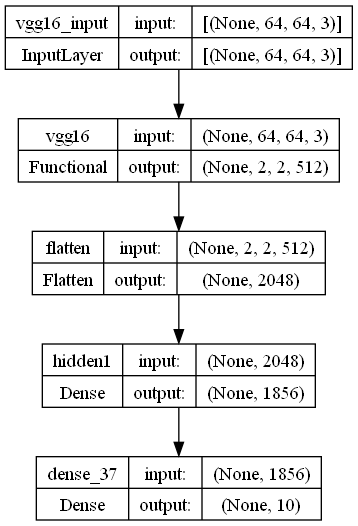

In [862]:
plot_model(best_vgg_model, show_shapes=True, show_layer_names=True)

<u>Plot History</u>

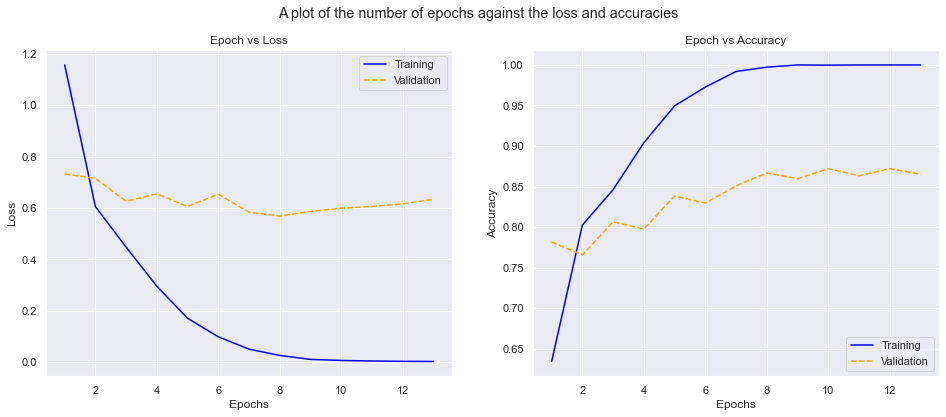

In [863]:
plot_history(best_vgg_model_history)

In [864]:
get_epoch(best_vgg_model_history)

The epoch with the lowest validation score is 8.
The validation loss for this epoch is 0.57.
The validation accuracy score for this epoch is 0.87


*Model Evaluation Metrics*

<u>Loading the best model</u>

In [865]:
best_vgg_model = load_model("checkpoints/vgg16/best_model.hdf5")

<u>Prediction Evaluation</u>

In [866]:
data = [ 
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

vgg_acc_pred = AccuracyPrediction(data, "neural network")
vgg_target_probs, vgg_target_preds = vgg_acc_pred.predict(best_vgg_model)

In [867]:
assert_correct_shape(vgg_target_probs, data, "probability")
assert_correct_shape(vgg_target_preds, data, "prediction")

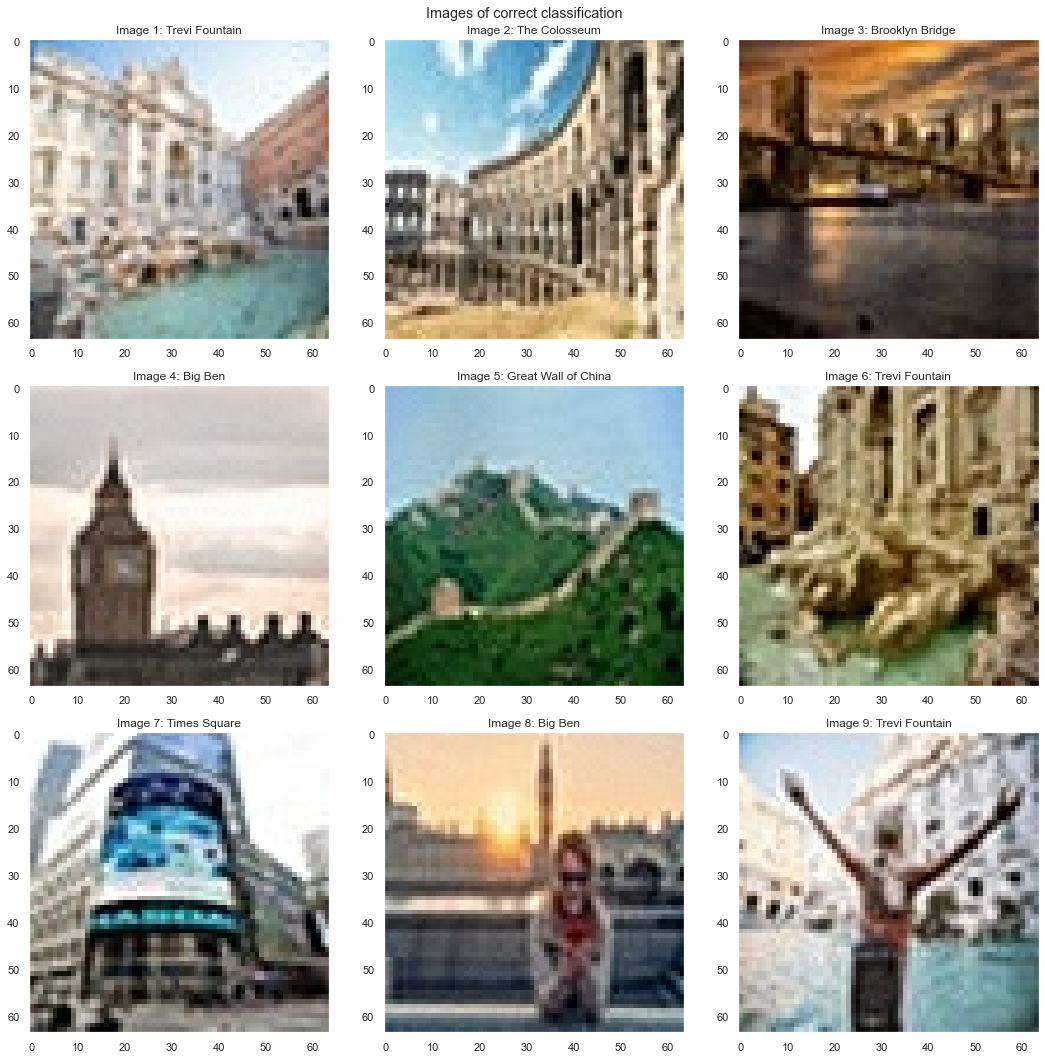

In [868]:
show_correct_images(data, vgg_target_preds, "correct")

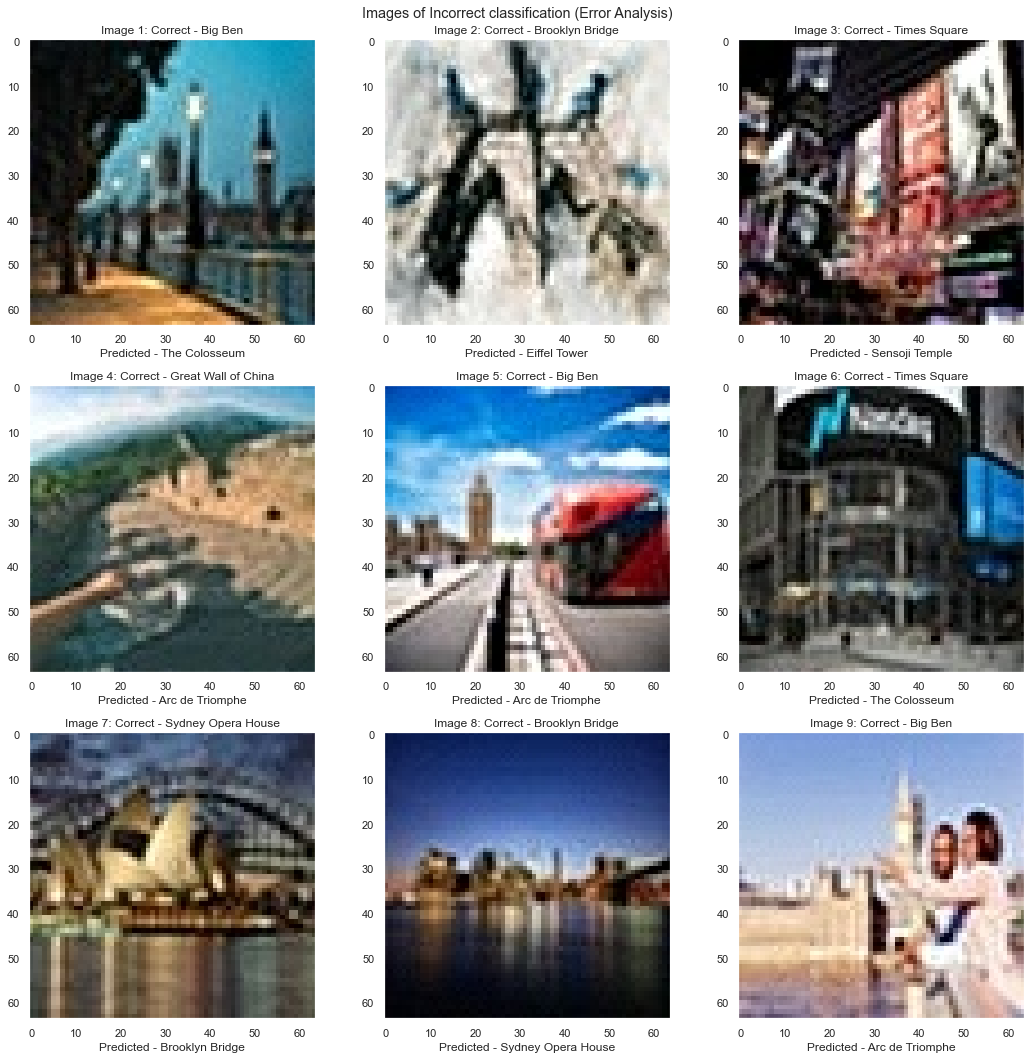

In [869]:
show_correct_images(data, vgg_target_preds, "incorrect")

<u>Accuracy Evaluation</u>

In [870]:
vgg_acc_pred.get_acc_loss(best_vgg_model)

The loss of our training data is 0.01.
The accuracy of our training data is 1.0.
The loss of our validation data is 0.57.
The accuracy of our validation data is 0.87.
The loss of our testing data is 0.55.
The accuracy of our testing data is 0.88.


<u>ROC-AUC Scores</u>

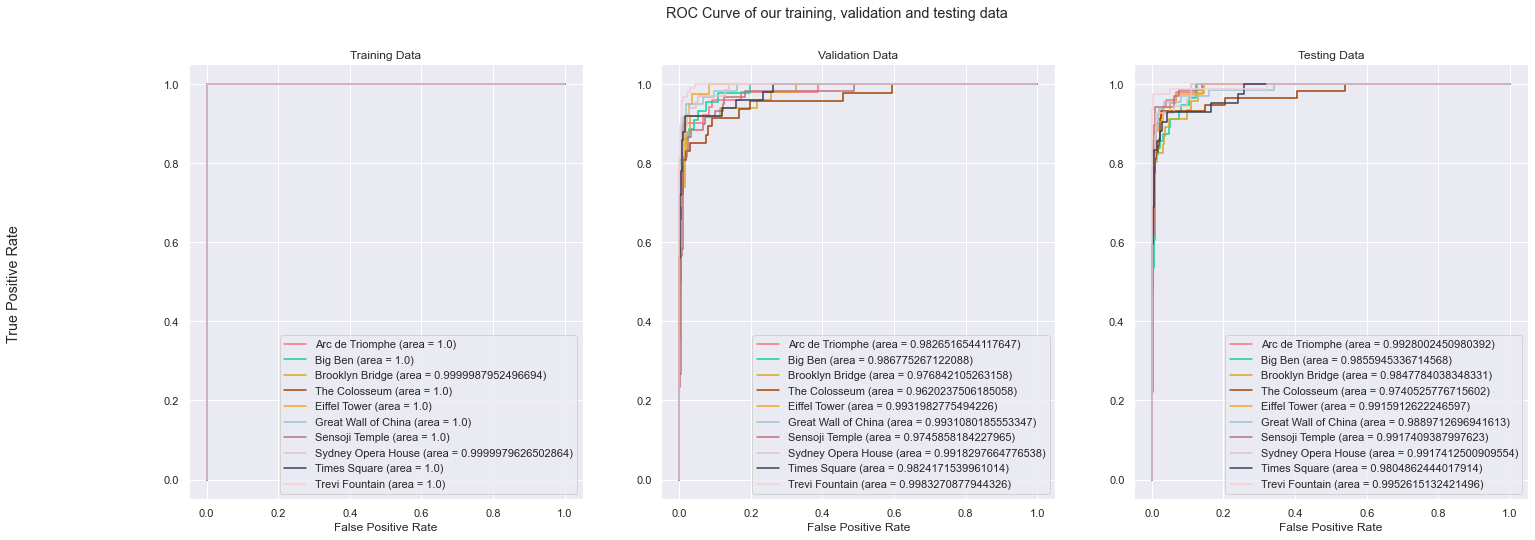

In [871]:
plot_all_curves(best_vgg_model, "neural_network", data)

In [872]:
roc_auc_vgg = RocAucScore(data, vgg_target_probs, y_train)
roc_auc_vgg.compute()

The ROC-AUC score for our training set is 1.0
The ROC-AUC score for our validation set is 0.984
The ROC-AUC score for our testing set is 0.988


<u>Confusion Matrix</u>

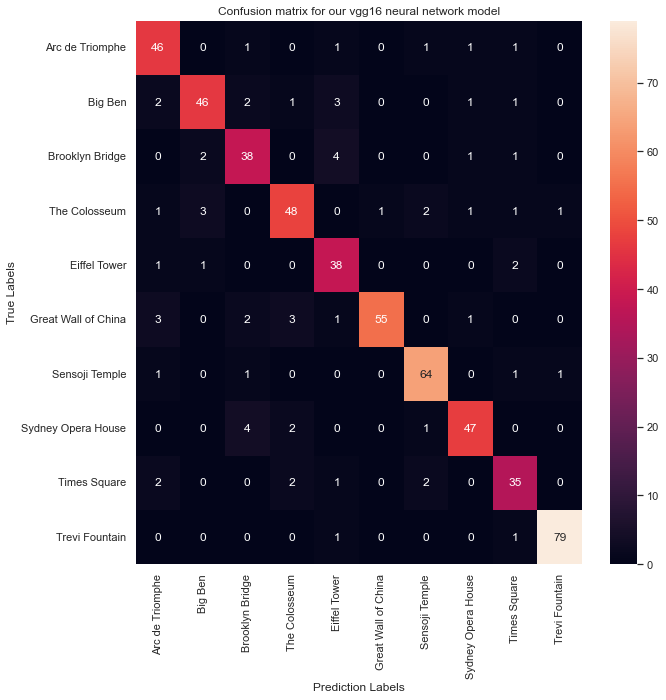

In [873]:
plot_confusion_matrix("vgg16 neural network", y_test, vgg_target_preds)

<u>Classification Report</u>

In [874]:
print_classification_report(y_test, vgg_target_preds[2])

                     precision    recall  f1-score   support

    Arc de Triomphe       0.82      0.90      0.86        51
            Big Ben       0.88      0.82      0.85        56
    Brooklyn Bridge       0.79      0.83      0.81        46
      The Colosseum       0.86      0.83      0.84        58
       Eiffel Tower       0.78      0.90      0.84        42
Great Wall of China       0.98      0.85      0.91        65
     Sensoji Temple       0.91      0.94      0.93        68
 Sydney Opera House       0.90      0.87      0.89        54
       Times Square       0.81      0.83      0.82        42
     Trevi Fountain       0.98      0.98      0.98        81

           accuracy                           0.88       563
          macro avg       0.87      0.87      0.87       563
       weighted avg       0.88      0.88      0.88       563



#### 